# Introduction

Notebook for generating figures from ICRN paper by Lee, Buse, Winfree.

As of writing, the command below will say that the session must be restarted due to a previous installation of numpy. After restarting the session, the cell one more below, "import tellurium as te", can be run.

NB: Tellurium is only required for the benchmarking section (example 0).

In [ ]:
!pip install tellurium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.5/128.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 126.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 100.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 84.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy

In [ ]:
import tellurium as te

Make the necessary changes to the path (to the directory where this notebook resides on your google drive).

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

working_dir_path = "gdrive/MyDrive/Colab Notebooks/2020_NeuralRD/DNA31 Examples"
working_dir_path = ""

%cd {working_dir_path}

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1jmy_SKCUME2D7sHXFGxTjIVD4IjYcm_8/DNA31 Examples


NB: Haiku is needed only for the Gray-Scott section (example 2).

In [ ]:
!pip install git+https://github.com/deepmind/dm-haiku

import haiku as hk
from haiku._src.data_structures import FlatMap

  Cloning https://github.com/deepmind/dm-haiku to /tmp/pip-req-build-ipgz212d
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/dm-haiku /tmp/pip-req-build-ipgz212d
  Resolved https://github.com/deepmind/dm-haiku to commit 8f105828d3126decc62bafc9888d8049556b7bc6
  Preparing metadata (setup.py) ... done
  Created wheel for dm-haiku: filename=dm_haiku-0.0.15.dev0-py3-none-any.whl size=373949 sha256=adbcdf346ab6db7be9ad719955d25ef74eb5448ff02372827a0762ce8f4c8366
  Stored in directory: /tmp/pip-ephem-wheel-cache-yik617lh/wheels/86/29/0a/454c478e7217c383ee3d05aa43cbeff48284c23430f59d0c4f
Successfully built dm-haiku


In [ ]:
import jax
from jax import random, jit, grad
import jax.numpy as jnp
from jax.nn import softmax, sigmoid
from jax.lax import fori_loop
import optax

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from functools import partial
import os
import numpy as np
import random as py_rand
from tqdm import tqdm
from IPython.display import clear_output
import pandas as pd
from PIL import Image
from skimage.transform import resize
import requests
from io import BytesIO

import timeit
from pathlib import Path
import pickle

Clone the icrn library from the github repository.

In [ ]:
!git clone https://github.com/SwissChardLeaf/icrn

Cloning into 'icrn'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 38 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (38/38), 5.69 MiB | 16.40 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [ ]:
%cd icrn

The processes for generating the data is included in this notebook but are often computationally intensive. The *_github directories will generally contain data used for producing the figures from the paper. Load them directly to plot figures. Note that starting any data generating process may overwrite your local copy of the reference data in these subdirectories!

In [ ]:
!ls

dimerization_data_github  Hopfield_data_github	README.md
GS_data_github		  icrn			WTA_data_github


Import from the icrn library.

In [ ]:
from icrn import many_species, many_rate_constants, many_index_symbols, MassActionReaction, ICRN, FastReaction, Experiment, relu, SJDict, map1
rxn = MassActionReaction

# Example 0: Dimer Network Benchmark

This section benchmarks the icrn library against Tellurium by simulating the dimerization network. The dimerization network considered does not require symmetry in k^1_ij and k^2_ij. Outputs will be made in the following sub directory.

In [ ]:
dn_dir = "dimerization_data_github/"

In [ ]:
def icrn_setup(n, m, d, k1, k2, dt):
    dn_exp_params = {
        "dt" : dt,
        "batch" : False,
        "integration_method" : "euler",
        "spatial_dim" : None
    }

    M, D = many_species("M D")
    K_1, K_2 = many_rate_constants("K_1 K_2")

    i, j = many_index_symbols("i j", n)

    dn_crn = ICRN([
        rxn(M[i] + M[j], D[i,j], K_1[i,j]),
        rxn(D[i,j], M[i] + M[j], K_2[i,j])
    ])

    dn_exp = Experiment(dn_crn, dn_exp_params)

    concs_spec = {
        M : jnp.array(m),
        D : jnp.array(d)
    }

    rate_spec = {
        K_1 : jnp.array(k1),
        K_2 : jnp.array(k2)
    }

    conc_data, rate_data, _ = dn_exp.dict_builder(concs_spec, rate_spec, {})
    return dn_exp, conc_data, rate_data, M, D

@partial(jax.jit, static_argnames = ['dn_exp', 'M', 'D'])
def icrn_sim(dn_exp, conc_data, rate_data, M, D):
    sim_concs, _ = dn_exp.simulate_time(conc_data, rate_data, {}, time=1.0)
    # block until ready is important for timing jax computations accuractely (jax asynchronous dispatch)
    return jax.block_until_ready(sim_concs[M]), jax.block_until_ready(sim_concs[D])

# Builds the string specification of reactions
def te_rxns(n):
    rxn_str = ""

    count = 0
    for i in range(n):
        for j in range(n):
            count += 1
            rxn_str += f"R{count}: M_{i} + M_{j} -> D_{i}_{j}; k1_{i}_{j}*M_{i}*M_{j}\n"
            count += 1
            rxn_str += f"R{count}: D_{i}_{j} -> M_{i} + M_{j}; k2_{i}_{j}*D_{i}_{j}\n"
    return rxn_str

# Builds the string specification of rate constants
def te_params(n, k1, k2):
    params_str = ""

    for i in range(n):
        for j in range(n):
            params_str += f"k1_{i}_{j} = {k1[i][j]}\n"

    for i in range(n):
        for j in range(n):
            params_str += f"k2_{i}_{j} = {k2[i][j]}\n"

    return params_str

# Builds the string specification of initial concentrations
def te_init_conds(n, m, d):
    init_conds_str = ""

    for i in range(n):
        init_conds_str += f"M_{i} = {m[i]}\n"

    for i in range(n):
        for j in range(n):
            init_conds_str += f"D_{i}_{j} = {d[i][j]}\n"

    return init_conds_str

# Return jax arrays for M and D concentrations at the last timepoint
def readout_te(n, result):
    build_m = np.zeros((n,))
    build_d = np.zeros((n, n))

    colnames = result.colnames
    end_concs = result[-1]

    for i in range(n):
        m_i_str = f"[M_{i}]"
        m_i_idx = colnames.index(m_i_str)
        build_m[i] = end_concs[m_i_idx]

    for i in range(n):
        for j in range(n):
            d_i_j_str = f"[D_{i}_{j}]"
            d_i_j_idx = colnames.index(d_i_j_str)
            build_d[i,j] = end_concs[d_i_j_idx]

    return jnp.array(build_m), jnp.array(build_d)

def te_setup(n, m, d, k1, k2):
    model_str = te_rxns(n) + te_params(n,k1,k2) + te_init_conds(n,m,d)
    model = te.loada(model_str)
    model.setIntegrator("cvode")
    model.getIntegrator().setValue('relative_tolerance', 1e-15)
    model.getIntegrator().setValue('absolute_tolerance', 1e-15)
    return model

Below is the loop that iterates over different values of n. Random intital concentrations and rate constants are generated. The set up and simulation times for icrn and Tellurium are collected, along with their relative error with respect to a gold standard simulation run with small dt.

In [ ]:
n_list = 5 * (np.arange(0, 12, 1) + 1) # used in paper; takes around 2 hours
# n_list = 10 * (np.arange(0, 4, 1) + 1) # faster version; takes around 30 minutes

py_rand.seed(12)

setup_repeat_num = 1
sim_repeat_num = 3 # reduce this for faster results

dt = 1e-3
steps = int(1/dt)

setup_time_data = []
sim_time_data = []
max_errors = []

for n_var in n_list:
    n = n_var

    print(f"beginning loop for n = {n}")

    m = [py_rand.random() for i in range(n)]
    d = [[py_rand.random() for j in range(n)] for i in range(n)]
    k1 = [[py_rand.random() for j in range(n)] for i in range(n)]
    k2 = [[py_rand.random() for j in range(n)] for i in range(n)]

    ### GOLD STANDARD SIMULATION ###
    gold_dt = 1e-6
    m_gold, d_gold = icrn_sim(*icrn_setup(n,m,d,k1,k2,gold_dt))

    ### SET UP ###

    dn_exp, conc_data, rate_data, M, D = icrn_setup(n,m,d,k1,k2,dt)
    model = te_setup(n,m,d,k1,k2)

    icrn_setup_time_list = timeit.repeat("icrn_setup(n,m,d,k1,k2,dt)", repeat=setup_repeat_num, number=1, globals=globals())
    te_setup_time_list = timeit.repeat("te_setup(n,m,d,k1,k2)", repeat=setup_repeat_num, number=1, globals=globals())

    setup_time_data.append([icrn_setup_time_list, te_setup_time_list])

    print(f"icrn setup took an average {np.array(icrn_setup_time_list).mean()}s across {setup_repeat_num} trials")
    print(f"tellurium setup took an average {np.array(te_setup_time_list).mean()}s across {setup_repeat_num} trials")

    ### SIMULATIONS ###

    def te_sim_readout(n):
        result = model.simulate(0, 1, steps)
        return readout_te(n, result)

    def te_sim():
        return model.simulate(0, 1, steps)

    m_icrn, d_icrn = icrn_sim(dn_exp, conc_data, rate_data, M, D)
    m_te, d_te = te_sim_readout(n)

    icrn_max_m_diff = jnp.abs((m_icrn - m_gold) / m_gold).max()
    icrn_max_d_diff = jnp.abs((d_icrn - d_gold) / d_gold).max()

    te_max_m_diff = jnp.abs((m_te - m_gold) / m_gold).max()
    te_max_d_diff = jnp.abs((d_te - d_gold) / d_gold).max()


    icrn_max_error = max(icrn_max_m_diff, icrn_max_d_diff)
    te_max_error = max(te_max_m_diff, te_max_d_diff)

    max_errors.append([icrn_max_error, te_max_error])

    icrn_sim_time_list = timeit.repeat("icrn_sim(dn_exp, conc_data, rate_data, M, D)", repeat=sim_repeat_num, number=1, globals=globals())
    te_sim_time_list = timeit.repeat("te_sim()", repeat=sim_repeat_num, number=1, globals=globals())

    sim_time_data.append([icrn_sim_time_list, te_sim_time_list])

    print(f"icrn simulation took an average {np.array(icrn_sim_time_list).mean()}s across {sim_repeat_num} trials")
    print(f"tellurium simulation took an average {np.array(te_sim_time_list).mean()}s across {sim_repeat_num} trials")


beginning loop for n = 5
compiling forward step function...
generating dynamics expressions
separating reactions by timescale
unifying
standardizing
unifying
standardizing
lambdifying expressions
no fast reactions
well-mixed, unbatched
done!
compiling forward step function...
generating dynamics expressions
separating reactions by timescale
unifying
standardizing
unifying
standardizing
lambdifying expressions
no fast reactions
well-mixed, unbatched
done!
compiling forward step function...
generating dynamics expressions
separating reactions by timescale
unifying
standardizing
unifying
standardizing
lambdifying expressions
no fast reactions
well-mixed, unbatched
done!
icrn setup took an average 0.01988773300001867s across 1 trials
tellurium setup took an average 0.05190914900003918s across 1 trials
icrn simulation took an average 0.013102473666625277s across 3 trials
tellurium simulation took an average 0.004119568000040393s across 3 trials
beginning loop for n = 10
compiling forward st

In [ ]:
setup_time_data_np = np.array(setup_time_data)
np.save(dn_dir + "setup_benchmark_data", setup_time_data_np)

sim_time_data_np = np.array(sim_time_data)
np.save(dn_dir + "sim_benchmark_data", sim_time_data_np)

max_errors_np = np.array(max_errors)
np.save(dn_dir + "max_errors", max_errors_np)

In [ ]:
setup_time_data_np = np.load(dn_dir + "setup_benchmark_data.npy")
sim_time_data_np = np.load(dn_dir + "sim_benchmark_data.npy")
max_errors_np = np.load(dn_dir + "max_errors.npy")

In [ ]:
icrn_setup_mean = np.mean(setup_time_data_np[:,0,:], axis=-1)
# icrn_setup_std = np.std(setup_time_data_np[:,0,:], axis=-1)

te_setup_mean = np.mean(setup_time_data_np[:,1,:], axis=-1)
# te_sim_std = np.std(setup_time_data_np[:,1,:], axis=-1)

icrn_sim_mean = np.mean(sim_time_data_np[:,0,:], axis=-1)
# icrn_sim_std = np.std(sim_time_data_np[:,0,:], axis=-1)

te_sim_mean = np.mean(sim_time_data_np[:,1,:], axis=-1)
# te_sim_std = np.std(sim_time_data_np[:,1,:], axis=-1)

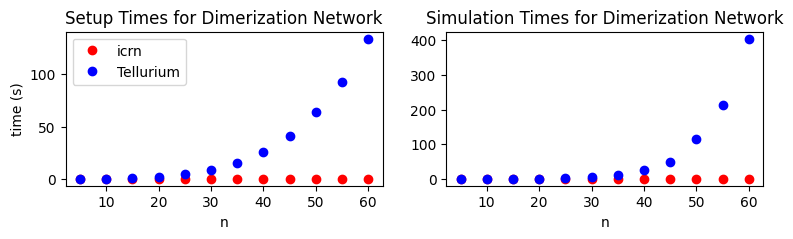

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,2))

ax1.set_title("Setup Times for Dimerization Network")
ax1.plot(n_list, icrn_setup_mean, label="icrn", c='r', marker="o", linestyle="")
ax1.plot(n_list, te_setup_mean, label="Tellurium", c='b', marker="o", linestyle="")
ax1.set_ylabel("time (s)")
ax1.set_xlabel("n")
ax1.legend(loc=2)

ax2.set_title("Simulation Times for Dimerization Network")
ax2.plot(n_list, icrn_sim_mean, label="icrn", c='r', marker="o", linestyle="")
ax2.plot(n_list, te_sim_mean, label="Tellurium", c='b', marker="o", linestyle="")
ax2.set_xlabel("n")

plt.savefig(dn_dir + "benchmark.png", dpi=300, bbox_inches='tight')

In [ ]:
max_errors_np

array([[0.02465555, 0.024669  ],
       [0.02959473, 0.02961208],
       [0.03916158, 0.03915492],
       [0.03441014, 0.03440971],
       [0.04150436, 0.04149801],
       [0.04988967, 0.04988932],
       [0.03776317, 0.0377614 ],
       [0.04003837, 0.04003461],
       [0.04199947, 0.04200167],
       [0.04314865, 0.04315069],
       [0.03957784, 0.03957513],
       [0.05213727, 0.05213662]], dtype=float32)

Text(0.5, 0, 'n')

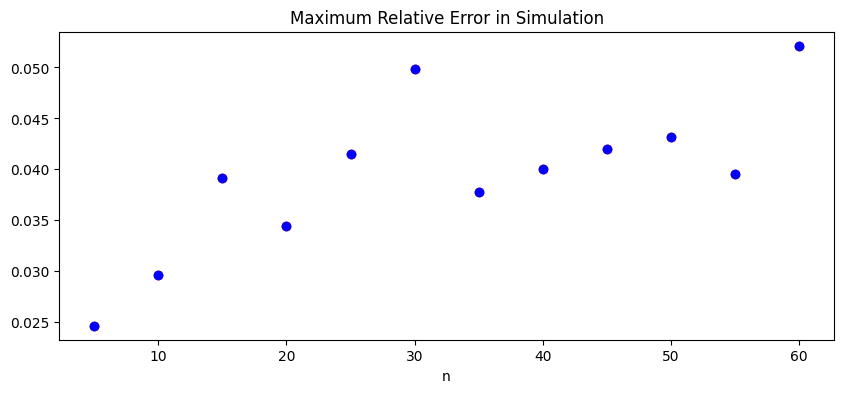

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))

ax.set_title("Maximum Relative Error in Simulation")
ax.plot(n_list, max_errors_np[:,0], label="icrn", c='r', marker="o", linestyle="")
ax.set_xlabel("n")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))

ax.set_title("Maximum Relative Error in Simulation")
ax.plot(n_list, max_errors_np[:,1], label="Tellurium", c='b', marker="o", linestyle="")
ax.set_xlabel("n")

In [ ]:
jnp.abs(max_errors_np[:,0] - max_errors_np[:,1])

Array([1.3446435e-05, 1.7350540e-05, 6.6608191e-06, 4.3213367e-07,
       6.3441694e-06, 3.5017729e-07, 1.7732382e-06, 3.7588179e-06,
       2.2016466e-06, 2.0414591e-06, 2.7045608e-06, 6.4820051e-07],      dtype=float32)

In [ ]:
print(f"at the largest n, icrn is {te_setup_mean[-1]/icrn_setup_mean[-1]}-fold faster for setup and {te_sim_mean[-1]/icrn_sim_mean[-1]}-fold faster for simulation.")

at the largest n, icrn is 3553.1091821645-fold faster for setup and 32499.927652310576-fold faster for simulation.


# Example 1: Winner Take All

In [ ]:
WTA_dir = "WTA_data_github/"

In [ ]:
X, W, XF, P, S, SG, A, RG, YF, Y, Rep, F = many_species("X W XF P S SG A RG YF Y Rep F")

alpha = many_rate_constants("alpha")

n = 100
m = 3

i = many_index_symbols("i", n)
j, k = many_index_symbols("j k", m)

rxn = MassActionReaction

wta_crn = ICRN([
    rxn(X[i] + W[i,j] + XF[i], X[i] + P[i,j], 36.),
    rxn(P[i,j] + SG[j], S[j], 36.),
    rxn(S[j] + S[k] + A[j,k], 0, alpha[j,k]),
    rxn(S[j] + RG[j] + YF[k], S[j] + Y[j], 1.8e-4),
    rxn(Y[j] + Rep[j], F[j], 3.6)
])

## Prepare MNIST Data

This section goes through the processing of the MNIST dataset. The 9 samples images used in Figure 4A,B are chosen in this section as well.

In [ ]:
from keras.datasets import mnist
import cv2
import numpy as np
from collections import defaultdict

(train_X, train_y), (test_X, test_y) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


We will be build the dataset by considering digits seven, eight, and nine.

In [ ]:
train_by_class_list = defaultdict(list)

for p in range(len(train_X)):
    if 9 - m < train_y[p]:
        train_by_class_list[train_y[p]].append(train_X[p])

train_by_class_np = {k : np.array(v) for (k,v) in train_by_class_list.items()}

test_by_class_list = defaultdict(list)

for p in range(len(test_X)):
    if 9 - m < test_y[p]:
        test_by_class_list[test_y[p]].append(test_X[p])

test_by_class_np = {k : np.array(v) for (k,v) in test_by_class_list.items()}

In [ ]:
def gray_scale_pixels(img):
    resample = cv2.resize(img, dsize=(12, 12), interpolation=cv2.INTER_CUBIC) / 255
    return resample[1:11, 1:11]

def binary_pixels(img):
    resample = cv2.resize(img, dsize=(12, 12), interpolation=cv2.INTER_CUBIC) / 255
    threshold = np.sort(resample, axis=None)[-21]
    resample = 1. * (resample - threshold) > 0
    return resample[1:11, 1:11]

For training, 5000 examples are chosen for each digit. For testing, 900 examples are chosen for each digit.

In [ ]:
N_train_class = 5000
N_test_class = 900

In [ ]:
train_X_concat = list()
train_Y_concat = list()

for (k,v) in train_by_class_np.items():
    train_X_concat.append(v[:N_train_class])

    one_hot_batch = np.zeros((N_train_class, m))
    one_hot_batch[:,k - (10 - m)] = 1
    train_Y_concat.append(one_hot_batch)

test_X_concat = list()
test_Y_concat = list()

for (k,v) in test_by_class_np.items():
    test_X_concat.append(v[:N_test_class])

    one_hot_batch = np.zeros((N_test_class, m))
    one_hot_batch[:,k - (10 - m)] = 1
    test_Y_concat.append(one_hot_batch)

In [ ]:
train_X_np = np.concatenate(train_X_concat)
test_X_np = np.concatenate(test_X_concat)

train_Y_np = np.concatenate(train_Y_concat)
test_Y_np = np.concatenate(test_Y_concat)

In [ ]:
gen = np.random.default_rng(seed=12)
gen.shuffle(train_X_np)
gen = np.random.default_rng(seed=12)
gen.shuffle(train_Y_np)

gen = np.random.default_rng(seed=12)
gen.shuffle(test_X_np)
gen = np.random.default_rng(seed=12)
gen.shuffle(test_Y_np)

Transform grayscale pixel values from MNIST sample images to binary values.

In [ ]:
train_X_b = np.ones((m * N_train_class, 10, 10))

for ex in range(m * N_train_class):
    train_X_b[ex, ...] = binary_pixels(train_X_np[ex, ...])

train_X_b = train_X_b.reshape((m * N_train_class, n))

In [ ]:
test_X_b = np.ones((m * N_test_class, 10, 10))

for ex in range(m * N_test_class):
    test_X_b[ex, ...] = binary_pixels(test_X_np[ex, ...])

test_X_b = test_X_b.reshape((m * N_test_class, n))

In [ ]:
def make_batches(batch_size, num_batches, data_X, data_Y):
    batch_list = list()

    for batch in range(num_batches):
        batch_X = data_X[batch * batch_size: (batch + 1) * batch_size]
        batch_Y = data_Y[batch * batch_size: (batch + 1) * batch_size]

        gen = np.random.default_rng(seed=batch)
        gen.shuffle(batch_X)
        gen = np.random.default_rng(seed=batch)
        gen.shuffle(batch_Y)

        batch_list.append((batch_X, batch_Y))

    return batch_list

A batchsize of 750 works on A100 on google colab. Change the batch size based on your hardware.

In [ ]:
train_batches = make_batches(750, 20, train_X_b, train_Y_np)

In [ ]:
W_init_unpruned = np.zeros((n, m))

for p in range(len(train_X_b)):
    c = np.argmax(train_Y_np[p])
    W_init_unpruned[:, c] += train_X_b[p]

W_init_unpruned = W_init_unpruned / N_train_class

In [ ]:
def take20norm(arr):
    threshold = np.sort(arr)[-21]
    arr = arr * ((arr - threshold) > 0)
    arr = arr / np.sum(arr)
    return arr

In [ ]:
W_init_concs = np.zeros((n, m))

for c in range(m):
    W_init_concs[:,c] = take20norm(W_init_unpruned[:,c])

In [ ]:
W_init_concs.shape

(100, 3)

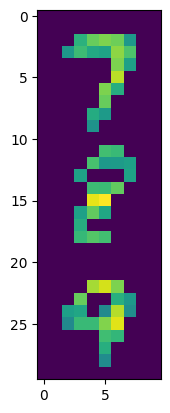

In [ ]:
plt.imshow(W_init_concs.T.reshape((30, 10)))

Select three examples from each digit class.

In [ ]:
concat_list = [train_by_class_np[7][[23, 20, 0]], train_by_class_np[8][[1, 23, 51]], train_by_class_np[9][[29, 47, 1]]]
img_batch = np.concatenate(concat_list)

processed_img_batch = np.zeros((9,10,10))

for im in range(9):
    processed_img_batch[im,...] = binary_pixels(img_batch[im,...])

processed_img_batch = processed_img_batch.reshape((9,100))

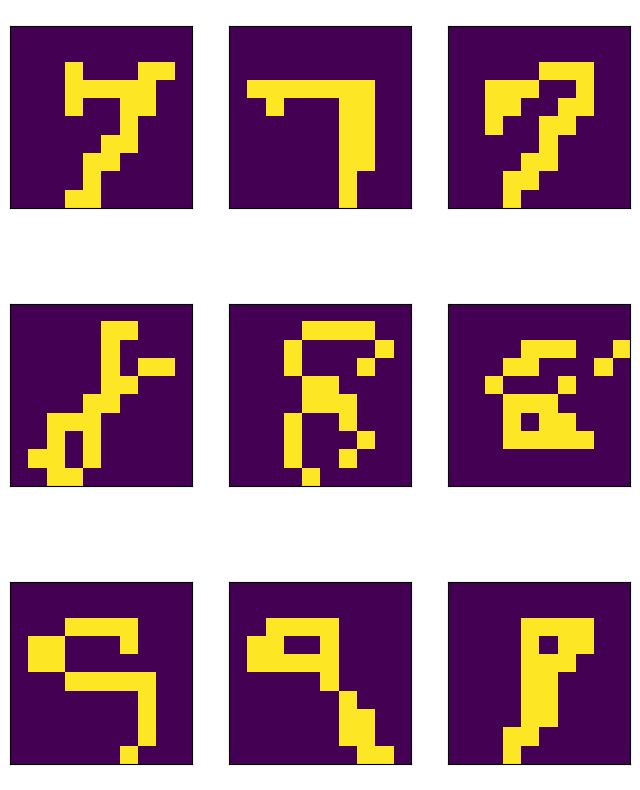

In [ ]:
plt.figure(figsize=[8,10])
plt.axis("off")
for img in range(9):
    ax = plt.subplot(3, 3, img+1)
    plt.imshow(processed_img_batch[img].reshape((10,10)))
    ax.set_xticks([])
    ax.set_yticks([])


plt.subplots_adjust(hspace=0.3)
plt.show()

In [ ]:
processed_target_batch = np.array(
    [
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]
    ]
)

## Batch Forward Simulation

The WTA simulation is in the well-mixed setting. Although the software interface to for well-mixed and reaction diffusion simulations are the same, under the hood, the two settings are treated separtely. In particular, the well-mixed version will be faster for well-mixed simulations because diffusion will not be performed.

In [ ]:
wta_exp_params = {
    "dt" : 1e-4,
    "batch" : True,
    "integration_method" : "euler",
    "spatial_dim" : None
}

wta_exp = Experiment(wta_crn, wta_exp_params)

compiling forward step function...
generating dynamics expressions
separating reactions by timescale
unifying
standardizing
unifying
standardizing
lambdifying expressions
no fast reactions
well-mixed, batched
done!


In [ ]:
concs_spec = {
    X : 5. * processed_img_batch,
    W : 100. * W_init_concs,
    XF : 2. * np.sum(100. * W_init_concs, axis=-1),
    SG : 100.,
    RG : 100.,
    A : 400.,
    YF :  200.,
    Rep : 200.,
    # below should start at zero
    P : 0.,
    S : 0.,
    Y : 0.,
    F : 0.
}

rate_data_spec = {
    alpha : 3.6e-3 * (np.ones((m,m)) - np.identity(m))
}

concs, rate_data, diff_data = wta_exp.dict_builder(concs_spec, rate_data_spec, {}, 9)

The time used in simulate_time will be based on the units the user provides in the rate constants. Here, the time units are hrs and concentration units are nM. Note that the leading dimension of the concentrations is time and the size will be sample_num+1 to account for the initial concentrations.

In [ ]:
sim_state, sim_hist = wta_exp.simulate_time(concs, rate_data, diff_data, 10., sample_num=1000)

In [ ]:
sim_hist[F].shape

(1001, 9, 3)

In [ ]:
def conc_gap(batch_concs, target_batch):
    return (batch_concs) * (2. * (target_batch - 0.5))

def make_F_figure_array(concs_hist):
    fig = plt.figure(1, figsize=[8, 6])
    plt.axis("off")
    fig.tight_layout()

    F_concs = concs_hist[F]

    gap_metrics = np.sum(conc_gap(concs_hist[F][-1], processed_target_batch), axis=-1)

    for c in range(3):
        for img in range(3):
            index = c*3 + img
            ax = plt.subplot(3, 3, index+1)
            ax.set_xlim(0, 10.)
            ax.set_ylim(0, 120)
            ax.set_yticks([0, 100], labels=["0", "100"], fontsize=15)
            ax.set_xticks([0, 10], labels=["0", "10"], fontsize=15)

            if c == 0 or c == 1:
                ax.tick_params(axis="x", which='both', bottom=False, labelbottom=False, labelsize=40)

            if img == 1 or img == 2:
                ax.tick_params(axis="y", which='both', left=False, labelleft=False, labelsize=20)

            plt.text(0.1, 105, "SUP: "+("%.2f" % gap_metrics[index]), fontsize=15)

            ax.plot(np.arange(0,1001,1) * 1e-2, F_concs[...,index,0], label = "$F_1$")
            ax.plot(np.arange(0,1001,1) * 1e-2, F_concs[...,index,1], label = "$F_2$")
            ax.plot(np.arange(0,1001,1) * 1e-2, F_concs[...,index,2], label = "$F_3$")

            if index == 2:
                ax.legend(loc=1, fontsize=15)

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.savefig(WTA_dir + "WTA_panelB.png", dpi=300)
    plt.show()

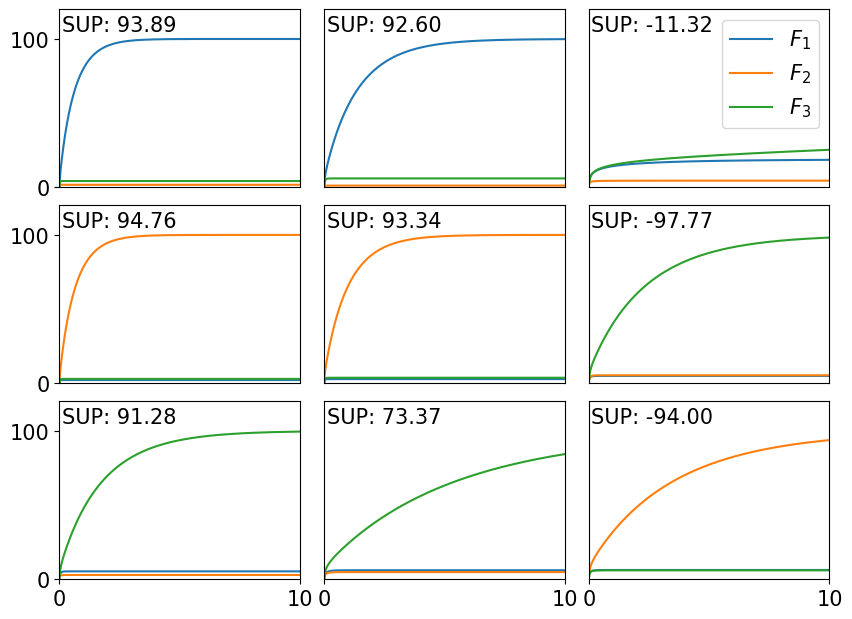

In [ ]:
make_F_figure_array(sim_hist)

## Multiclass Training

The WTA system could be trained on a variety of loss functions. For our work, we choose to train to maximize a superiority metric, roughly capturing the distance between the correct and all other incorrect classifications. We also train for accuracy with a loss function that applies a softmax on the fluorescence output with L_(1/2) regularization.

In [ ]:
def normSum(W):
    return W / jnp.sum(W, axis = 0)

@partial(jit, static_argnums=2)
def get_WTA_output_concs(weights, xs, scan_length=1e5):
    concs_spec = {
        X : 5. * xs,
        W : 100. * weights,
        XF : 2. * np.sum(100. * weights, axis=-1),
        SG : 100.,
        RG : 100.,
        A : 400.,
        YF :  200.,
        Rep : 200.,
        # below should start at zero
        P : 0.,
        S : 0.,
        Y : 0.,
        F : 0.
    }

    rate_data_spec = {
        alpha : 3.6e-3 * (np.ones((m,m)) - np.identity(m))
    }

    concs, rate_data, diff_data = wta_exp.dict_builder(concs_spec, rate_data_spec, {}, len(xs))
    sim_state, _ = wta_exp.simulate_segments(concs, rate_data, diff_data, scan_length=scan_length)
    return sim_state[F]

@jit
def get_WTA_output_ps(W, X):
    return softmax(get_WTA_output_concs(W, X, scan_length=2e3))

def conc_gap_loss(W, input_batch, target_batch):
    batch_concs = get_WTA_output_concs(W, input_batch, scan_length=2e3)
    return - jnp.sum(conc_gap(batch_concs, target_batch))

@jit
def update_W_gap(W, input_batch, target_batch, learning_rate):
    gradients = grad(conc_gap_loss)(W, input_batch, target_batch)
    return W - gradients * learning_rate

def softmax_reg_loss(W, input_batch, target_batch, alpha=100):
    batch_ps = get_WTA_output_ps(W, input_batch)
    res = - jnp.sum(jnp.log(batch_ps) * target_batch)
    res += alpha * jnp.sum(jnp.sqrt(W))
    return res

@jit
def update_W_softmax_reg(W, input_batch, target_batch, learning_rate):
    gradients = grad(softmax_reg_loss)(W, input_batch, target_batch)
    return W - gradients * learning_rate

@jit
def test_parameters_batch(W, input_batch, target_batch):
    batch_concs = get_WTA_output_concs(W, input_batch)

    predictions = jnp.argmax(batch_concs, axis=-1)
    targets = jnp.argmax(target_batch, axis=-1)

    acc = jnp.count_nonzero(predictions == targets) / input_batch.shape[0]
    avg_gap = jnp.sum(conc_gap(batch_concs, target_batch)) / input_batch.shape[0]

    return acc, avg_gap

def test_parameters(W, batch_list):
    running_batch_acc = 0
    running_batch_avg_gap = 0

    for batch in batch_list:
        input_batch, target_batch = batch
        acc, avg_gap = test_parameters_batch(W, input_batch, target_batch)

        running_batch_acc += acc
        running_batch_avg_gap += avg_gap

    return running_batch_acc / len(batch_list), running_batch_avg_gap / len(batch_list)

def get_random_W(key):
    return random.uniform(random.key(key), (n,m))

def WTA_acc(W, input_batch, target_batch):
    weighted_sums = jnp.matmul(input_batch, W)

    preds = jnp.argmax(weighted_sums, axis=-1)
    target_class = jnp.argmax(target_batch, axis=-1)

    return jnp.count_nonzero(preds==target_class) / input_batch.shape[0]

uniform_init = jnp.ones((100,3)) / 100

The update_f determines the loss function that is used. There is a function for each of the two loss functions that are explored. The weights updates are done using plain mini batch gradient descent.

In [ ]:
def train_protocol(epochs, update_f, exp_dir, lr, param_W, norm=True, mask=False, train_stats=True):
    param_W_best_acc = param_W
    param_W_best_avg_gap = param_W

    if train_stats:
        train_acc, train_avg_gap = test_parameters(param_W, train_batches)
        print("initial train accuracy =", train_acc)
        print("initial train average SUP =", train_avg_gap)

    test_acc, test_avg_gap = test_parameters_batch(param_W, test_X_b, test_Y_np)
    print("initial test accuracy =", test_acc)
    print("initial test average SUP =", test_avg_gap)
    wta_acc = WTA_acc(param_W, test_X_b, test_Y_np)
    print("winner take all computation accuracy", wta_acc)

    acc_best = test_acc
    avg_gap_best = test_avg_gap

    print("saving initial weights")
    W_init_file_path = os.path.join(exp_dir, "W_init.npy")
    jnp.save(WTA_dir + W_init_file_path, param_W)

    for epoch in range(epochs):
        epoch += 0
        print("starting epoch #", epoch+1)

        for batch in train_batches:
            input_batch, target_batch = batch
            param_W = update_f(param_W, input_batch, target_batch, lr)
            param_W = jax.nn.relu(param_W)

            if norm:
                param_W = normSum(param_W)

        file_path = os.path.join(exp_dir, "W_epoch"+str(epoch+1)+".npy")
        jnp.save(WTA_dir + file_path, param_W)
        print("Nonzero Elements:", jnp.count_nonzero(param_W))
        print("Sum of Weight Elements", jnp.sum(param_W))

        if train_stats:
            train_acc, train_avg_gap = test_parameters(param_W, train_batches)
            print("train accuracy =", train_acc)
            print("train average SUP =", train_avg_gap)

        test_acc, test_avg_gap = test_parameters_batch(param_W, test_X_b, test_Y_np)
        print("test accuracy =", test_acc)
        print("test average SUP =", test_avg_gap)
        wta_acc = WTA_acc(param_W, test_X_b, test_Y_np)
        print("winner take all computation accuracy", wta_acc)


        if test_acc > acc_best:
            print("improved accuracy")
            acc_best = test_acc
            param_W_best_acc = param_W

        if test_avg_gap > avg_gap_best:
            print("improved average SUP")
            avg_gap_best = test_avg_gap
            param_W_best_avg_gap = param_W

    print("saving highest accuracy weights, which achieved an accuracy of", str(acc_best))
    W_best_file_path = os.path.join(exp_dir, "W_best_acc.npy")
    jnp.save(WTA_dir + W_best_file_path, param_W_best_acc)

    print("saving highest average SUP weights, which achieved an average SUP of", str(avg_gap_best))
    W_best_file_path = os.path.join(exp_dir, "W_best_avg_gap.npy")
    jnp.save(WTA_dir + W_best_file_path, param_W_best_avg_gap)

The following two cells will each begin a training procedure.

In [ ]:
# 50 epochs takes roughly 7 minutes
train_protocol(50, update_W_gap, "gap", 5e-8, uniform_init, train_stats=False)

In [ ]:
# 30 epochs takes roughly 4 minutes
train_protocol(30, update_W_softmax_reg, "acc_reg", 1e-7, uniform_init, norm=False, train_stats=False)

In [ ]:
gap_W = jnp.load(WTA_dir + "gap/" + "W_best_avg_gap.npy")
acc_W = jnp.load(WTA_dir + "acc_reg/" + "W_epoch30.npy")

In [ ]:
weights = [normSum(W_init_unpruned), W_init_concs, gap_W, acc_W]

for weight in weights:
    print(jnp.sum(weight, axis=0))
    test_acc, test_avg_gap = test_parameters_batch(weight, test_X_b, test_Y_np)
    print("test accuracy:", str(test_acc))
    print("test average SUP:", str(test_avg_gap))
    print("nonzero elements:", str(jnp.count_nonzero(weight)))
    wta_acc = WTA_acc(weight, test_X_b, test_Y_np)
    print("winner take all computation accuracy", wta_acc)

[1.0000001  0.9999998  0.99999964]
test accuracy: 0.8374074
test average SUP: 42.812767
nonzero elements: 262
winner take all computation accuracy 0.8296296
[1.        1.        1.0000001]
test accuracy: 0.8144444
test average SUP: 52.47566
nonzero elements: 60
winner take all computation accuracy 0.81333333
[0.9999998  0.9999998  0.99999976]
test accuracy: 0.82
test average SUP: 62.06066
nonzero elements: 148
winner take all computation accuracy 0.8192593
[0.03928764 0.05948279 0.04461509]
test accuracy: 0.8622222
test average SUP: 41.46019
nonzero elements: 24
winner take all computation accuracy 0.8625926


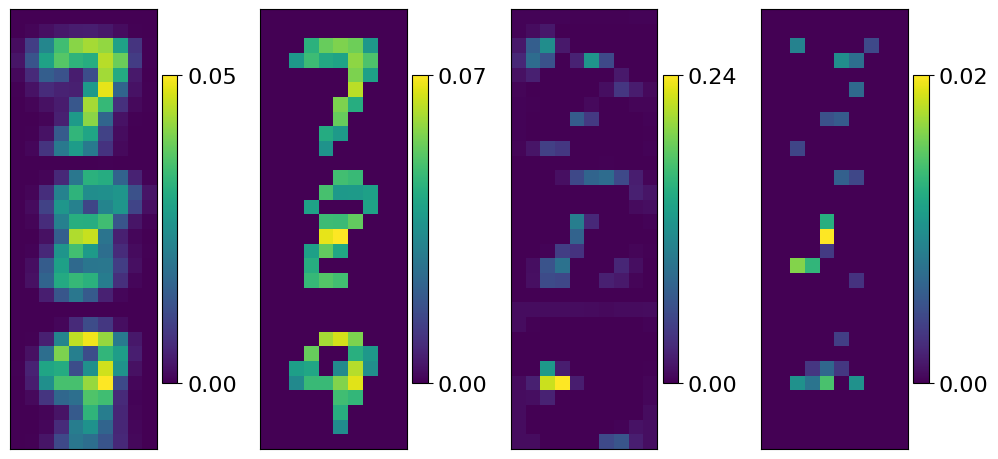

In [ ]:
fig, ax = plt.subplots(1, len(weights), figsize=([12,10]))

for w in range(len(weights)):
    col = ax[w].imshow(weights[w].T.reshape((30,10)))
    ax[w].set_xticks([])
    ax[w].set_yticks([])

    min_w = weights[w].min()
    max_w = weights[w].max()

    cb = fig.colorbar(col, ticks=[min_w, max_w], ax=ax[w], shrink=0.4, pad=0.03, location='right')
    cb.ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    cb.ax.tick_params(labelsize=16)

plt.subplots_adjust(wspace=0.4)
plt.savefig(WTA_dir + "WTA_panelC.png", dpi=300)

# Example 2: Gray Scott

In [ ]:
gs_dir = "GS_data_github/"

U, V = many_species("U V")
F, k = many_rate_constants("F k")

gs_crn = ICRN([
    rxn(U + 2*V, 3*V, 1),
    rxn(V, 0, F+k),
    rxn(0, U, F),
    rxn(U, 0, F)
])

gs_exp_params = {
    "dt" : 1,
    "dh" : 1,
    "batch" : False,
    "integration_method" : "relu_RK4",
    "spatial_dim" : (101,101)
}

H, W = gs_exp_params["spatial_dim"]
gs_exp = Experiment(gs_crn, gs_exp_params)

compiling forward step function...
generating dynamics expressions
separating reactions by timescale
unifying
standardizing
unifying
standardizing
lambdifying expressions
no fast reactions
reaction diffusion, unbatched
done!


The following sets up the VGG network used for the loss function. The weights for the network must be downloaded from this link: https://github.com/davisyoshida/vgg16-haiku/tree/main?tab=readme-ov-file.

The weights should be added to the Gray Scott subdirectory. For example: icrn/GS_data_github/weights.pkl

In [ ]:
# VGG code in Haiku (JAX) from here: https://github.com/davisyoshida/vgg16-haiku/tree/main?tab=readme-ov-file
# Based on PyTorch code from here: https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py

# NB: we are using only up to third max-pool layer of VGG
# we return the features from each max-pool layer for Gram matrix calculations

vgg_weights_name = "weights.pkl"

CFG = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M']

class Features(hk.Module):
    def __call__(self, x):
        module_num = 0
        features = []
        for layer_type in CFG:
            if layer_type == 'M':
                x = hk.max_pool(x, window_shape=2, strides=2, padding='VALID', channel_axis=0)
                module_num += 1
                features.append(x)
            else:
                conv = hk.Conv2D(layer_type, kernel_shape=3, padding=(1,1), data_format='NCHW', name=f'conv_{module_num}')
                x = conv(x)
                module_num += 1
                x = jax.nn.relu(x)
                module_num += 1
        return x, features

class VGG16(hk.Module):
    def __call__(self, x):
        """x should be in CHW format"""

        x, features = Features(name='features')(x)

        outputs = {'features': features}

        return outputs

def _dicts_to_flatmappings(tree):
    if isinstance(tree, dict):
        return FlatMap(**{k: _dicts_to_flatmappings(v) for k, v in tree.items()})
    return tree

def get_model(weights_location='weights.pkl'):
    weights_location = Path(weights_location)
    with weights_location.open('rb') as f:
        weights = pickle.load(f)

    weights = jax.tree.map(jnp.array, weights)
    weights = _dicts_to_flatmappings(weights)

    def model_fn(x):
        return VGG16(name='model')(x)

    model = hk.transform(model_fn)
    model = hk.without_apply_rng(model)

    return model, weights

model_vgg16, weights_vgg16 = get_model(weights_location = gs_dir + vgg_weights_name)
len(weights_vgg16.keys()) # should be 16

16

In [ ]:
# Helper functions

@jax.jit
def compute_gram_matrix(features):
    # Reshape to (channels, height*width)
    features_flat = features.reshape(features.shape[0], -1)
    # Compute Gram matrix
    gram = jnp.matmul(features_flat, features_flat.T)
    # Normalize by number of elements
    return gram / features_flat.shape[1]

@jax.jit
def jit_extract_feature_grams(image):
    output = model_vgg16.apply(weights_vgg16, image)
    gram_matrices = [compute_gram_matrix(feat) for feat in output['features']]
    return gram_matrices

@jax.jit
def texture_loss(target_grams, generated_grams):
    loss = 0
    for target_g, gen_g in zip(target_grams, generated_grams):
        # Mean squared error between Gram matrices
        loss += jnp.mean(jnp.square(target_g - gen_g))
    return loss

@jax.jit
def normalise(channel):
    return (channel - channel.min()) / (channel.max() - channel.min())

@jax.jit
def state_to_image(state):
    # VGG model expects CHW image
    # convert to RGB and normalise to [0, 1]
    r = normalise(state[V])
    g = normalise(state[U])
    b = 1 - (r + g)/2
    return jnp.stack([r, g, b], axis=-1)

@jax.jit
def state_to_rgb(state):
    # VGG model expects CHW image
    # convert to RGB, no normalisation
    r = state[V]
    g = state[U]
    b = 1 - (r + g)/2
    return jnp.stack([r, g, b], axis=0)

# generate initial conditions for simulations
V_init = np.zeros((H,W))
V_init[H//2-1:H//2+2,W//2-1:W//2+2] = 1
def generate_initial(key):
    noise = 0.18*random.uniform(key, shape=(H,W))
    return {
        U : 1. + noise,
        V : V_init + noise
    }

# generate parameter initialisations
# these are at distance r and angle theta from the specified centre
def gen_params_circle(centre, r, theta):
    rate_data = SJDict({
        F : centre[F]  + r * jnp.cos(theta),
        k : centre[k] + r * jnp.sin(theta)
    })

    return rate_data

In [ ]:
# Core simulation and loss functions

scan_f = gs_exp.forward_step_f

diff_data_spec = {
    U : 0.2,
    V : 0.1
}
_, _, diff_data = gs_exp.dict_builder({}, {}, diff_data_spec)

def simulate_rd_segment(concs, rate_data, segment_steps, dt):

    def scan_helper(x, _):
        new_x = scan_f(x, rate_data, diff_data, dt)
        return new_x, new_x

    sim_concs, _ = jax.lax.scan(scan_helper, init=concs, length=segment_steps)

    return sim_concs

def simulate_rd_checkpoint(rate_data, init_concs_spec, num_segments, segment_steps):
    init_concs, _, _ = gs_exp.dict_builder(init_concs_spec, {}, {})
    sim_concs, _ = gs_exp.simulate_segments(init_concs, rate_data, diff_data, segments=num_segments, scan_length=segment_steps)
    return sim_concs

def soft_well_regularizer(theta, lower=0.0, upper=1.0, gain=10.0):
    penalty = 2 - jnp.tanh(gain * (theta - lower)) + jnp.tanh(gain * (theta - upper))
    return 0.25 * penalty**2

@partial(jax.jit, static_argnums=(5,))
def loss_fn(rate_data, initial_state, target_grams, mu, logvar, segment_steps, dt):
    x = simulate_rd_segment(initial_state, rate_data, segment_steps, dt)
    im = state_to_rgb(x)
    generated_grams = jit_extract_feature_grams(im)

    # Texture loss
    loss = 0.5 * texture_loss(target_grams, generated_grams)

    # Moments-matching loss
    loss += jnp.square(x[V].mean() - mu[0])
    loss += jnp.square(x[U].mean() - mu[1])
    loss += jnp.square(jnp.log(x[V].var()) - logvar[0])
    loss += jnp.square(jnp.log(x[U].var()) - logvar[1])

    # Regularisation
    loss += 100 * soft_well_regularizer(rate_data[k], lower=0.025, upper=0.085, gain=200)
    loss += 100 * soft_well_regularizer(rate_data[F], lower=0.005, upper=0.085, gain=200)

    return loss, x

The following shows the potential well regularization.

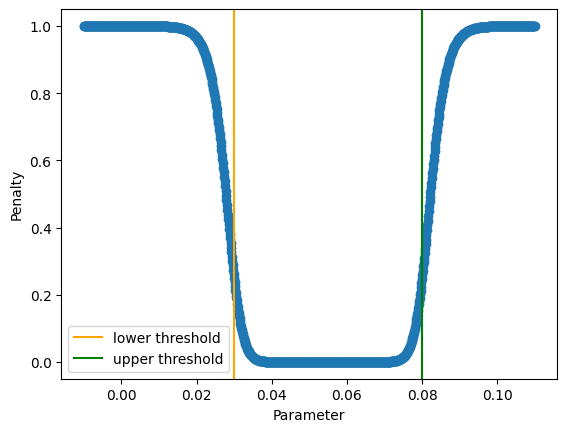

In [ ]:
lower = 0.03
upper = 0.08
gain = 200

xs = jnp.linspace(-0.01, 0.11, 1000)
plt.scatter(xs, soft_well_regularizer(xs, lower, upper, gain))
plt.axvline(lower, label='lower threshold', c='orange')
plt.axvline(upper, label='upper threshold', c='g')
plt.legend(loc='lower left')
plt.xlabel("Parameter")
plt.ylabel("Penalty")
plt.show()

In [ ]:
# target parameters known to give interesting patterns
# greek-letter classifications are from Pearson's 1991 paper

named_params = {
    "Pink Maze on Green ($\kappa$)" : {
        F : 0.037,
        k : 0.06
    },

    "Green Spots on Pink ($\lambda$)" : {
        F : 0.036,
        k : 0.05725
    },

    "Pink Spots on Green ($\delta$)" : {
        F : 0.034,
        k : 0.063
    }
}

The cell below generates the results of forward simulation using the three pattern types from above.

Pink Maze on Green ($\kappa$)
mid vs end loss:  3.1330876
mean_mid:    [0.16322877 0.57299286]
mean_end:    [0.17197703 0.54913235]
logvar_mid:  [-4.3397636 -3.3545315]
logvar_end:  [-4.3842635 -3.5659008] 

Green Spots on Pink ($\lambda$)
mid vs end loss:  3.373933
mean_mid:    [0.2082587  0.46387234]
mean_end:    [0.21437503 0.4446982 ]
logvar_mid:  [-4.9245415 -3.849083 ]
logvar_end:  [-5.192926  -4.3678718] 

Pink Spots on Green ($\delta$)
mid vs end loss:  29.037773
mean_mid:    [0.0308156 0.913638 ]
mean_end:    [0.11181904 0.68100095]
logvar_mid:  [-5.0417356 -3.535317 ]
logvar_end:  [-4.26665   -3.3990662] 



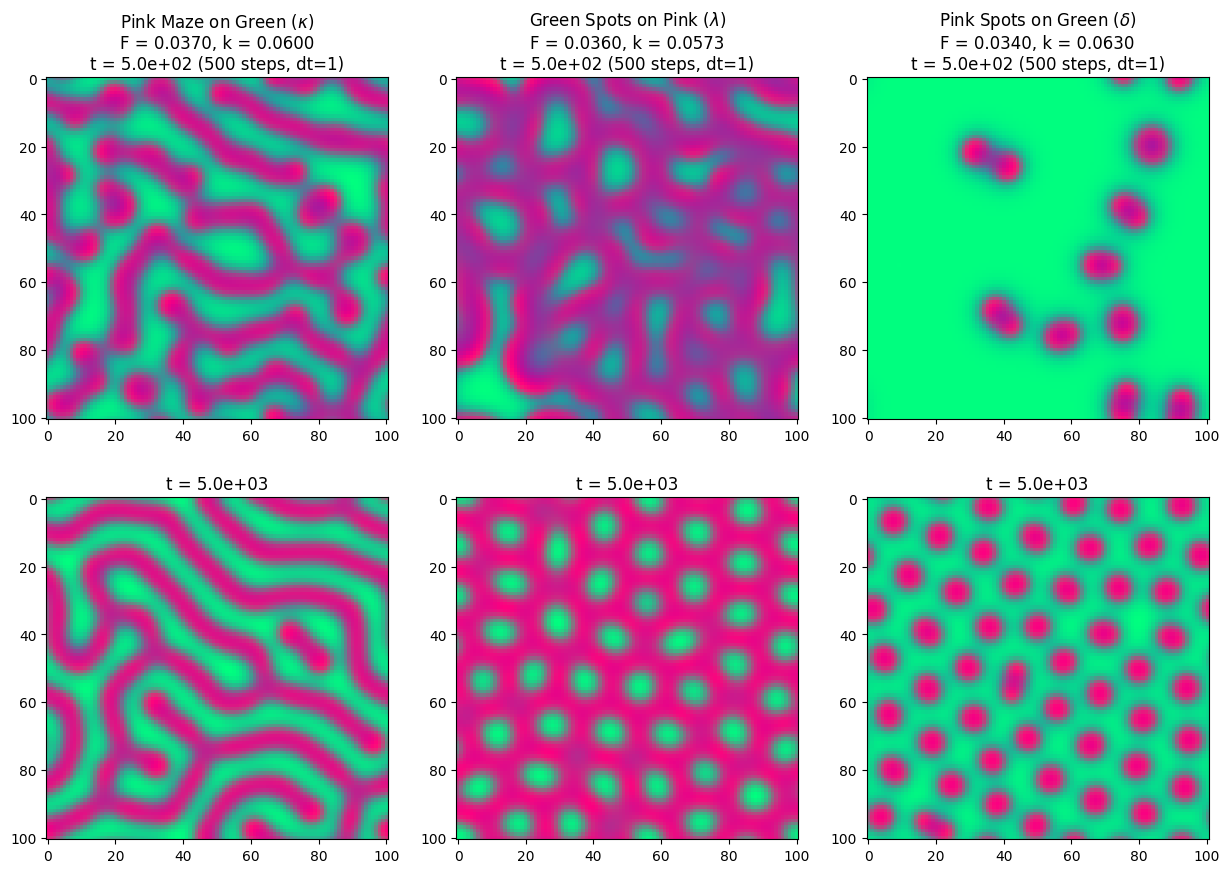

In [ ]:
# save the target outputs and Gram matrices for each pattern type

num_segments_mid = 5
num_segments_end = 45
segment_steps = 100

named_targets = {}

noisy_init_concs_spec = generate_initial(random.PRNGKey(0))

for name, rate_data in named_params.items():
    local_dict = {}
    params = SJDict(rate_data)
    target_mid = simulate_rd_checkpoint(params, noisy_init_concs_spec, num_segments=num_segments_mid, segment_steps=segment_steps)
    local_dict["target_mid"] = target_mid
    target_end = simulate_rd_checkpoint(params, target_mid, num_segments=num_segments_end, segment_steps=segment_steps)
    local_dict["target_end"] = target_end

    tar_mid = state_to_rgb(target_mid)
    local_dict["target_grams_mid"] = jit_extract_feature_grams(tar_mid)
    tar_end = state_to_rgb(target_end)
    local_dict["target_grams_end"] = jit_extract_feature_grams(tar_end)

    mean_mid = jnp.array([jnp.mean(target_mid[V]), jnp.mean(target_mid[U])])
    logvar_mid = jnp.log(jnp.array([jnp.var(target_mid[V]), jnp.var(target_mid[U])]))

    mean_end = jnp.array([jnp.mean(target_end[V]), jnp.mean(target_end[U])])
    logvar_end = jnp.log(jnp.array([jnp.var(target_end[V]), jnp.var(target_end[U])]))

    named_targets[name] = local_dict

    print(name)
    print("mid vs end loss: ", texture_loss(local_dict["target_grams_mid"], local_dict["target_grams_end"]))
    print("mean_mid:   ", mean_mid)
    print("mean_end:   ", mean_end)
    print("logvar_mid: ", logvar_mid)
    print("logvar_end: ", logvar_end, "\n")


scl = 5
num_names = len(named_params.keys())
fig, axs = plt.subplots(2, num_names, figsize=(num_names*scl, 2*scl))
for i, (name, params) in enumerate(named_params.items()):
    axs[0, i].imshow(state_to_image(named_targets[name]["target_mid"]))
    axs[0, i].set_title(f"{name}\nF = {params[F]:.4f}, k = {params[k]:.4f}\nt = {num_segments_mid*segment_steps*gs_exp_params['dt']:.1e} ({num_segments_mid*segment_steps} steps, dt={gs_exp_params['dt']})")

    axs[1, i].imshow(state_to_image(named_targets[name]["target_end"]))
    axs[1, i].set_title(f"t = {(num_segments_mid + num_segments_end)*segment_steps*gs_exp_params['dt']:.1e}")

plt.savefig(gs_dir+"TargetTextures.png")

The following generates noised initial conditions and collects data for the moments-matching loss.

In [ ]:
# sampling different initial conditions for each target parameter set
# used to calculate the mean average concentrations and log-variances, for the moments-matching loss

n_inits = 10

num_segments = 50
segment_steps = 100

for name, rate_data in named_params.items():

    params = SJDict(rate_data)

    data_loc = np.zeros((n_inits, 4))

    for i in range(n_inits):

        noisy_init_concs_spec = generate_initial(random.PRNGKey(i))

        target = simulate_rd_checkpoint(rate_data, noisy_init_concs_spec, num_segments=num_segments, segment_steps=segment_steps)

        data_loc[i, :2] = jnp.array([jnp.mean(target[V]), jnp.mean(target[U])])
        data_loc[i, 2:] = jnp.log(jnp.array([jnp.var(target[V]), jnp.var(target[U])]))

    named_targets[name]["sampled_mean"] = data_loc[:, :2].mean(axis=0)
    named_targets[name]["sampled_logvar"] = data_loc[:, 2:].mean(axis=0)


The following is the training loop used for generating the trajectories seen in Fig 5. The outer most loop iterates through the pattern types. The middle loop iterates through different initializations of F, k on the circle around the target F, k values. The inner most loop iterates through the training steps.

This cell takes roughly 30 minutes to run on a Colab A100 GPU. Saved outputs from our training run may be loaded in the following cell, if you prefer not to run this out.

In [ ]:
# main training loop
# initialise the parameters in a ring around the targer parameters
# can skip this and use next cell to load training history, if desired

filename = gs_dir + "GS_training_outputs.pkl"
training_outputs = {}

num_segments = 1
segment_steps = 300

train_steps = 201

DISP_INTERVAL = 20

n_thetas = 10
thetas = np.linspace(0, 2*np.pi*((n_thetas-1)/n_thetas), n_thetas)
r = 0.015

lr_early = 0.00005
lr_late = 0.0005

loss_value = jnp.inf
break_loss = -jnp.inf

key1 = random.PRNGKey(0)

# loop through target parameters
for i, (name, target_params) in enumerate(named_params.items()):

    print(name)

    local_dict = {}
    local_dict['target_params'] = target_params

    target_grams = named_targets[name]['target_grams_end']
    target_mu = named_targets[name]['sampled_mean']
    target_logvar = named_targets[name]['sampled_logvar']

    loss_log = np.zeros((n_thetas, train_steps))
    param_history = np.zeros((n_thetas, train_steps+1, 2))
    break_point = np.zeros((n_thetas,))

    best_loss = jnp.inf

    # loop through initialisations
    pbar_outer = tqdm(enumerate(thetas), desc="Training Outer...")
    for j, theta in enumerate(thetas):

        rate_data = gen_params_circle(target_params, r=r, theta=theta)
        param_history[j, 0] = np.array([[rate_data[F], rate_data[k]]])

        @partial(jax.jit, static_argnums=(5,))
        def step_inner(params, initial_state, target, target_mu, target_logvar, segment_steps, dt, lr):
            (loss_value, simulated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, initial_state, target, target_mu, target_logvar, segment_steps, dt)
            grads = map1(lambda x: jnp.clip(x, min=-1, max=1), grads)
            params = params - grads * lr
            return params, loss_value, simulated_state

        key1 = random.PRNGKey(0)

        # loop through training steps
        pbar = tqdm(range(train_steps), desc=f"{name}")
        for p in pbar:

            key1, key2, key3 = random.split(key1, num=3)

            init_concs = named_targets[name]['target_end']

            lr = max(lr_early, lr_late - loss_value * ((lr_late - lr_early)/5000))

            rate_data, loss_value, x = step_inner(rate_data, init_concs, target_grams, target_mu, target_logvar, segment_steps, 1.0, lr)

            if loss_value < best_loss:
                best_loss = loss_value
                best_params = map1(lambda x: x.copy(), rate_data)

            if loss_value < break_loss:
                loss_log[j, p] = loss_value
                F_loc = rate_data[F]
                k_loc = rate_data[k]
                param_history[j, 1+p] = np.array([[F_loc, k_loc]])
                break_point[j] = 1+p
                break

            loss_thresh = 1
            dist_thresh = 0.001
            kick = 0.002
            n_mem = 3

            if p > n_mem and jnp.abs(rate_data[F] - param_history[j, p-n_mem+1:p+1, 0].mean()) < dist_thresh and jnp.abs(rate_data[k] - param_history[j, p-n_mem:p, 1].mean()) < dist_thresh:

                rate_data[k] += (loss_value > loss_thresh) * kick * random.normal(key2)
                rate_data[k] = jnp.clip(rate_data[k], min=0.03, max=0.08)

                rate_data[F] += (loss_value > loss_thresh) * kick * random.normal(key3)
                rate_data[F] = jnp.clip(rate_data[F], min=0.005, max=0.08)

            loss_log[j, p] = loss_value
            F_loc = rate_data[F]
            k_loc = rate_data[k]
            param_history[j, 1+p] = np.array([[F_loc, k_loc]])

            print("step", p, "params", rate_data, "loss value", loss_value)

            if p % DISP_INTERVAL == 0:
                clear_output()
                fig, axs = plt.subplots(1, 3, figsize=(12,4))
                im = axs[0].imshow(state_to_image(x))
                axs[0].set_title(f'{num_segments*segment_steps} steps, dt={gs_exp_params["dt"]:.3f}, t={gs_exp_params["dt"]*num_segments*segment_steps:.3f}\n U: min: {x[U].min():.3f}, max: {x[U].max():.3f} \n V: min: {x[V].min():.3f}, max: {x[V].max():.3f}')
                axs[1].scatter(range(p+1), loss_log[j, :p+1])
                axs[1].set_xlabel('step')
                axs[1].set_ylabel('loss')
                t = range(p+1)
                axs[2].scatter(param_history[j, :p+1, 0], param_history[j, :p+1, 1], c=t, cmap='viridis')
                axs[2].scatter(target_params[F], target_params[k], marker="*", color='red')
                axs[2].set_xlabel('F')
                axs[2].set_ylabel('k')
                axs[2].set_xlim(0, 0.1)
                axs[2].set_ylim(0, 0.1)
                plt.tight_layout()
                plt.show()
                print(f'Step {i}, loss={loss_value:.4f}, min loss={loss_log[j, :p+1].min():.4f}, F={F_loc:.3f}, k={k_loc:.3f}')

        local_dict["param_history"] = jnp.array(param_history)
        local_dict["loss_log"] = jnp.array(loss_log)
        local_dict["break_point"] = jnp.array(break_point)
        local_dict["best_params"] = best_params
        local_dict["best_loss"] = best_loss

        training_outputs[name] = local_dict

        with open(filename, "wb") as f:
            pickle.dump(training_outputs, f)

Training outputs are saved.

In [ ]:
# for loading saved training outputs

filename = gs_dir + "GS_training_outputs.pkl"

with open(filename, "rb") as f:
    training_outputs_load = pickle.load(f)

training_outputs = training_outputs_load.copy()

The next cell is used to compute the loss landscape over parameters F and k for the loss function defined above. This cell takes roughly 20 minutes to run. Again, saved loss landscape data may be loaded in the cell after next.

In [ ]:
# evaluate the loss landscape for the 'initialise concentrations at target' task

# can skip this and use next cell to load loss landscapes, if desired

training_outputs_landscape = {}
filename = gs_dir + "GS_training_outputs_landscape.pkl"

# should be same as in training loop
num_segments = 1
segment_steps = 300

dt = 1.0

num_F = 101
num_k = 101
Fs = np.linspace(0.0, 0.08, num_F)
ks = np.linspace(0.03, 0.08, num_k)

vmin = np.inf
vmax = -np.inf

for i, (name, target_params) in enumerate(named_params.items()):

    print(name)

    local_dict = {}
    local_dict['target_params'] = target_params

    target_grams = named_targets[name]['target_grams_end']
    target_mu = named_targets[name]['sampled_mean']
    target_logvar = named_targets[name]['sampled_logvar']

    key1, key2, key3 = random.split(key1, num=3)

    initial_state = named_targets[name]['target_end']

    losses = np.zeros((num_F, num_k))

    for eff, F0 in enumerate(Fs):
        for kay, k0 in enumerate(ks):

            params = SJDict({
                F : F0,
                k : k0
            })

            loss, (state, _) = loss_fn(params, initial_state, target_grams, target_mu, target_logvar, segment_steps, dt)
            losses[eff, kay] = loss

    losses = jnp.array(losses)
    log_losses = jnp.log10(losses)
    local_dict['loss_landscape'] = losses
    local_dict['log_loss_landscape'] = log_losses
    local_dict['Fs'] = jnp.array(Fs)
    local_dict['ks'] = jnp.array(ks)

    training_outputs_landscape[name] = local_dict

    with open(filename, "wb") as f:
        pickle.dump(training_outputs_landscape, f)

    vmin = min(vmin, losses[losses !=-np.inf].min())
    vmax = max(vmax, losses[losses !=np.inf].max())

training_outputs['vmin'] = vmin
training_outputs['vmax'] = vmax

with open(filename, "wb") as f:
    pickle.dump(training_outputs_landscape, f)

In [ ]:
ll = training_outputs_landscape['Green Spots on Pink ($\\lambda$)']['loss_landscape']

In [ ]:
amin = ll.argmin()
ll[amin//101, amin%101]

Array(0.00185883, dtype=float32)

In [ ]:
Fs[amin//101]

Array(0.0352, dtype=float32)

In [ ]:
ks[amin%101]

Array(0.057, dtype=float32)

In [ ]:
params = SJDict({
        F : 0.0352,
        k : 0.057
    })

In [ ]:
psF = training_outputs['Green Spots on Pink ($\\lambda$)']['param_history'][:, :, 0]
psF = psF.flatten()
psk = training_outputs['Green Spots on Pink ($\\lambda$)']['param_history'][:, :, 1]
psk = psk.flatten()
closest = ((psF - 0.036)**2 + (psk - 0.0573)**2).argmin()
params = SJDict({F: psF[closest], k: psk[closest]})

In [ ]:
segment_steps

100

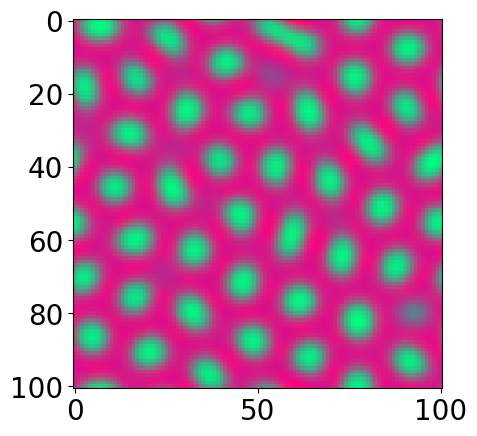

In [ ]:
initial_state = generate_initial(random.PRNGKey(42))
initial_state, _, _ = gs_exp.dict_builder(initial_state, {}, {})
state = simulate_rd_checkpoint(params, initial_state, num_segments=50, segment_steps=100)

plt.imshow(state_to_image(state))
plt.savefig('lowest_loss')

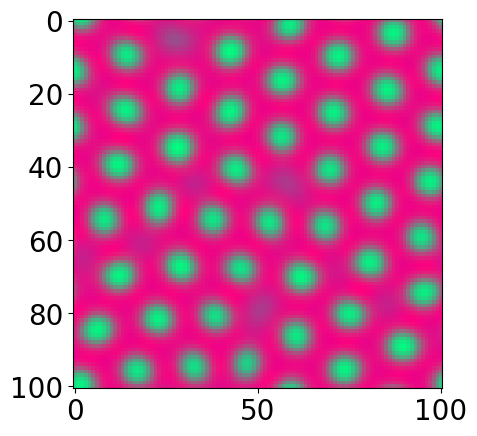

In [ ]:
initial_state = named_targets['Green Spots on Pink ($\\lambda$)']['target_end']
initial_state, _, _ = gs_exp.dict_builder(initial_state, {}, {})
state = simulate_rd_checkpoint(params, initial_state, num_segments=50, segment_steps=100)

plt.imshow(state_to_image(state))
plt.savefig('closest')

In [ ]:
filename = gs_dir + "GS_training_outputs_landscape.pkl"

with open(filename, "rb") as f:
    training_outputs_landscape_load = pickle.load(f)

training_outputs_landscape = training_outputs_landscape_load.copy()
vmin = training_outputs_landscape['vmin']
vmax = training_outputs_landscape['vmax']

The training outputs are used to generate the figures. The remaining cells in the Gray Scott section are dedicated to plotting.

In [ ]:
size = 20

plt.rc('font', size=size)
plt.rc('axes', titlesize=size)
plt.rc('axes', labelsize=size)
plt.rc('xtick', labelsize=size)
plt.rc('ytick', labelsize=size)
plt.rc('legend', fontsize=size)
plt.rc('figure', titlesize=size)

def sci_fmt(x, precision=2, exp_digits=2):
    s = f"{x:.{precision}e}"
    coeff, exp = s.split('e')
    exp_sign = '+' if int(exp) >= 0 else '-'
    exp_val = abs(int(exp))
    return f"{coeff}e{exp_sign}{exp_val:0{exp_digits}d}"

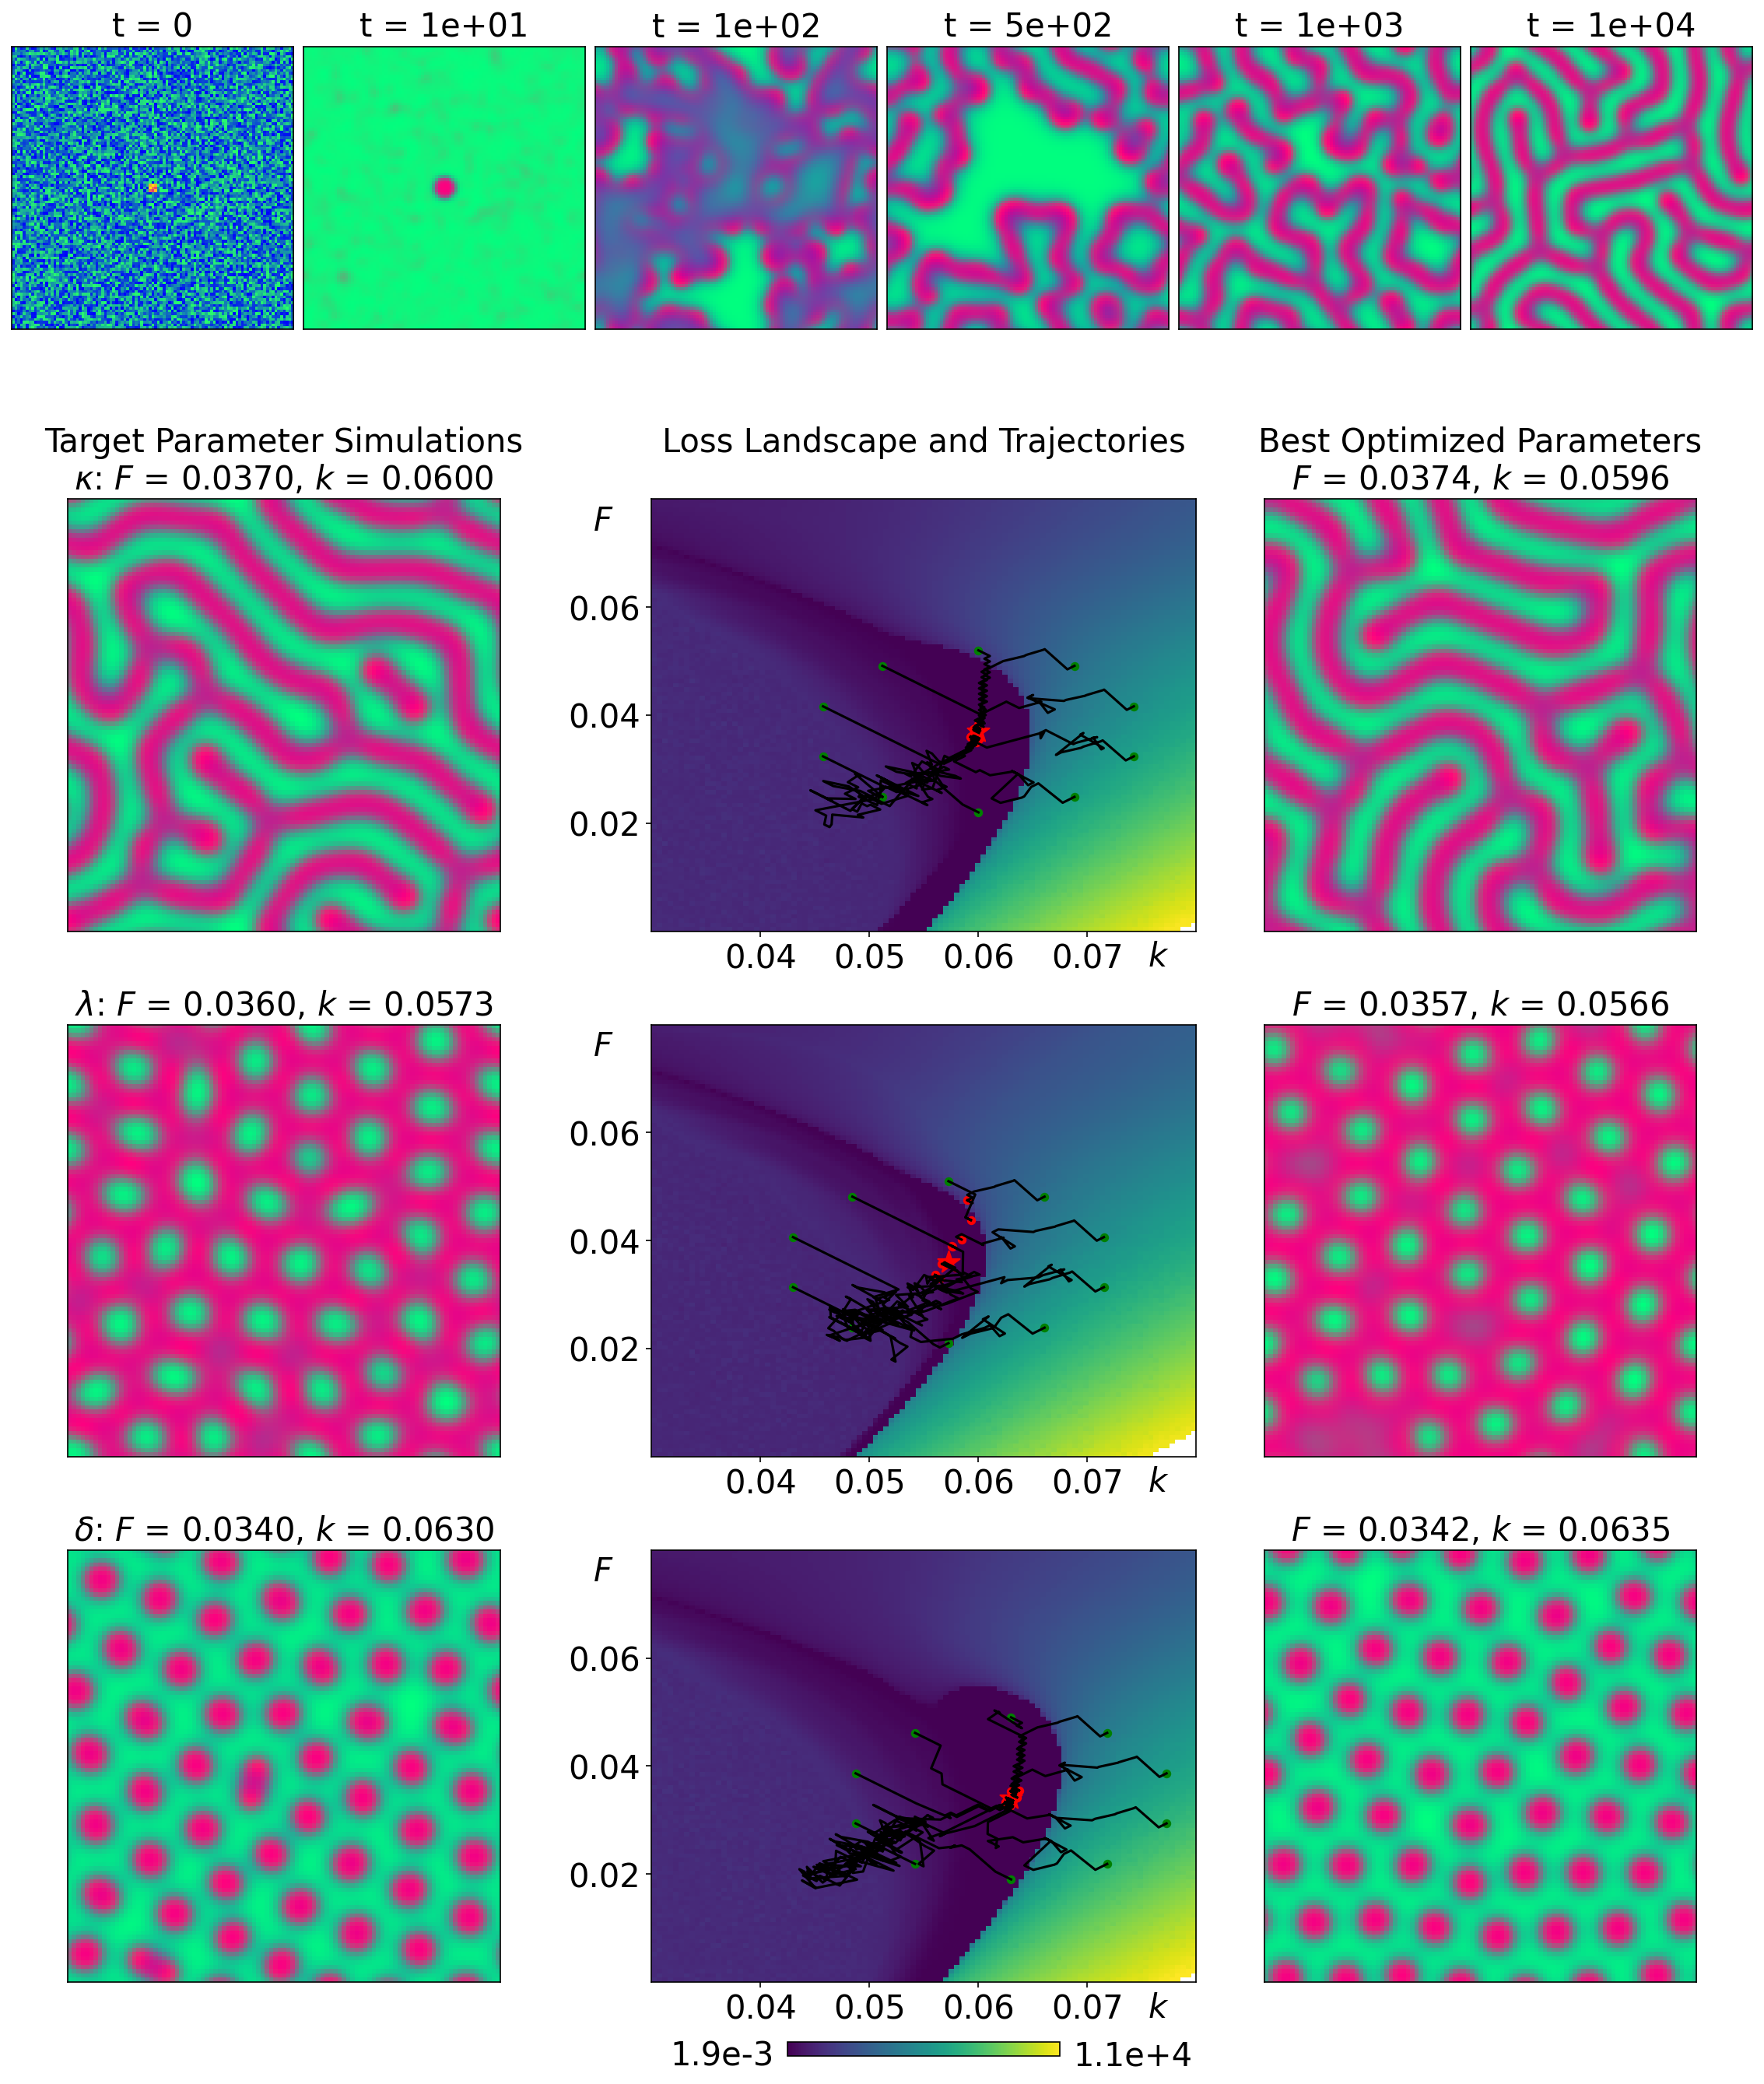

In [ ]:
# generate the main figure

num_segments = 50
segment_steps = 100
dt = 1.0
initial_state = generate_initial(random.PRNGKey(0))

num_names = len(named_params.keys())

scl = 4
ratio = 1.3
fig = plt.figure(layout="constrained", figsize=(15, 18), dpi=150)
subfigs = fig.subfigures(2, 1, height_ratios=[1, num_names*ratio])

# top row: time-evolution of a single simulation

state = initial_state
segments_list = [1,4,5,90]
n_increments = len(segments_list)
segments_curr = 0

name = "Pink Maze on Green ($\kappa$)"
rate_data = named_params[name]

params = SJDict(rate_data)

axs0 = subfigs[0].subplots(1, (2+n_increments))
axs0[0].imshow(state_to_image(noisy_init_concs_spec))
axs0[0].set_title(f"t = {segments_curr*segment_steps*gs_exp_params['dt']}")
axs0[0].set_xticks([])
axs0[0].set_yticks([])

state, _, _ = gs_exp.dict_builder(noisy_init_concs_spec, {}, {})
state = simulate_rd_segment(state, rate_data, 100, 0.1)
axs0[1].imshow(state_to_image(state))
axs0[1].set_title(f"t = {100*0.1:.0e}")
axs0[1].set_xticks([])
axs0[1].set_yticks([])

for i, delta_segments in enumerate(segments_list):
    state = simulate_rd_checkpoint(params, state, num_segments=delta_segments, segment_steps=segment_steps)
    segments_curr += delta_segments
    axs0[i+2].imshow(state_to_image(state))
    axs0[i+2].set_title(f"t = {segments_curr*segment_steps*gs_exp_params['dt']:.0e}")
    axs0[i+2].set_xticks([])
    axs0[i+2].set_yticks([])

# bottom rows: targets, with corresponding loss landscapes, training trajectories, and best outputs

axs1 = subfigs[1].subplots(num_names, 3)
greeks = ['$\kappa$', '$\lambda$', '$\delta$']
for i, (name, rate_data) in enumerate(named_params.items()):
    axs1[i,0].imshow(state_to_image(named_targets[name]["target_end"]))
    if i == 0:
        axs1[i,0].set_title(f"Target Parameter Simulations\n{greeks[i]}: $F$ = {rate_data[F]:.4f}, $k$ = {rate_data[k]:.4f}")
    else:
        axs1[i,0].set_title(f"{greeks[i]}: $F$ = {rate_data[F]:.4f}, $k$ = {rate_data[k]:.4f}")
    axs1[i,0].set_xticks([])
    axs1[i,0].set_yticks([])

    losses = training_outputs_landscape[name]['loss_landscape']
    ks = training_outputs_landscape[name]['ks']
    Fs = training_outputs_landscape[name]['Fs']
    img = axs1[i,1].imshow(losses, extent=[ks.min(), ks.max(), Fs.min(), Fs.max()], vmin=vmin, vmax=vmax)
    axs1[i,1].set_aspect("auto")
    fig = axs1[i,1].figure

    if i == 2:
        cb = fig.colorbar(img, ticks=[vmin, vmax], ax=axs1[i, 1], shrink=0.5, pad=0.03, location='bottom')
        cb.ax.xaxis.set_ticks_position('none')
        cb.ax.xaxis.set_ticklabels([])
        cb.ax.text(-0.05, -0.0, sci_fmt(vmin, 1, 1), va='center', ha='right', transform=cb.ax.transAxes)
        cb.ax.text(1.05, -0.0, sci_fmt(vmax, 1, 1), va='center', ha='left', transform=cb.ax.transAxes)

    axs1[i,1].text(0.95, -0.06, '$k$',
        transform=axs1[i,1].transAxes,
        va='center', ha='right')
    axs1[i,1].set_xticks([0.04, 0.05, 0.06, 0.07])

    axs1[i,1].text(-0.07, 0.95, '$F$',
        transform=axs1[i,1].transAxes,
        va='center', ha='right')
    axs1[i,1].set_yticks([0.02, 0.04, 0.06])

    if i == 0:
        axs1[i,1].set_title('Loss Landscape and Trajectories\n')

    param_history = training_outputs[name]['param_history']
    for j, trajectory in enumerate(param_history):
        loss_log = training_outputs[name]['loss_log'][j]
        break_point = int(training_outputs[name]['break_point'][j])
        if break_point != 0:
            trajectory = trajectory[:break_point]
            loss_log = loss_log[:break_point-1]

        t = range(len(trajectory))
        axs1[i,1].plot(trajectory[:, 1], trajectory[:, 0], color='black')

        # plot start and end points for each trajectory
        axs1[i,1].scatter(trajectory[0, 1], trajectory[0, 0], marker="o", color='green', s=20)
        axs1[i,1].scatter(trajectory[-1, 1], trajectory[-1, 0], marker="o", color='red', s=20)

    axs1[i,1].set_xlim(0.03, 0.08)
    axs1[i,1].set_ylim(0, 0.08)

    axs1[i,1].scatter(rate_data[k], rate_data[F], marker="*", color='red', s=200)

    # params = training_outputs[name]['best_params']
    amin = training_outputs[name]['loss_log'][:, -1].argmin()
    fmin, kmin = training_outputs[name]['param_history'][amin, -1]
    params = SJDict({F: fmin, k: kmin})

    initial_state = generate_initial(random.PRNGKey(1))
    initial_state, _, _ = gs_exp.dict_builder(initial_state, {}, {})
    initial_state = simulate_rd_checkpoint(rate_data, initial_state, num_segments=num_segments, segment_steps=segment_steps)
    state = simulate_rd_checkpoint(params, initial_state, num_segments=num_segments, segment_steps=segment_steps)

    axs1[i,2].imshow(state_to_image(state))
    F_loc = params[F]
    k_loc = params[k]
    if i == 0:
        axs1[i,2].set_title(f"Best Optimized Parameters\n$F$ = {F_loc:.4f}, $k$ = {k_loc:.4f}")
    else:
        axs1[i,2].set_title(f"$F$ = {F_loc:.4f}, $k$ = {k_loc:.4f}")
    axs1[i,2].set_xticks([])
    axs1[i,2].set_yticks([])

plt.savefig(gs_dir + 'GrayScottFigure.png')

# Example 3: Hopfield CRN

In [ ]:
hf_dir = "Hopfield_data_github/"

The Hopfield CRN is defined using FastReaction. Fast reaction completely depletes the limiting reagent in a single time step.

In [ ]:
n = 256

Up, Un = many_species("Up Un")
Wp, Wn, Up_deg, Un_deg = many_rate_constants("Wp Wn Up_deg Un_deg")
i, j = many_index_symbols("i j", n)

hf_crn = ICRN([
    rxn(Up[i], Up[i]+Up[j], relu(Wp[i,j])),
    rxn(Up[i], Up[i]+Un[j], relu(-Wp[i,j])),
    rxn(Un[i], Un[i]+Up[j], relu(Wn[i,j])),
    rxn(Un[i], Un[i]+Un[j], relu(-Wn[i,j])),

    rxn(3*Up[i], 2*Up[i], Up_deg[i]),
    rxn(3*Un[i], 2*Un[i], Un_deg[i]),

    FastReaction(Up[i]+Un[i], 0) # fast reactions use up the limiting reagent
])

hf_exp_params = {
    "dt" : 0.1,
    "dh" : 1.,
    "batch" : False,
    "integration_method" : "relu_RK4",
    "spatial_dim" : (100, 100)
}

hf_exp = Experiment(hf_crn, hf_exp_params)

compiling forward step function...
generating dynamics expressions
separating reactions by timescale
unifying
standardizing
unifying
standardizing
lambdifying expressions
reaction diffusion, unbatched
done!


## Image Preparation

Here, we prepare the target image that will be used in the training process.

(1067, 800, 3)
Shape: 88x88
(88, 88, 3)


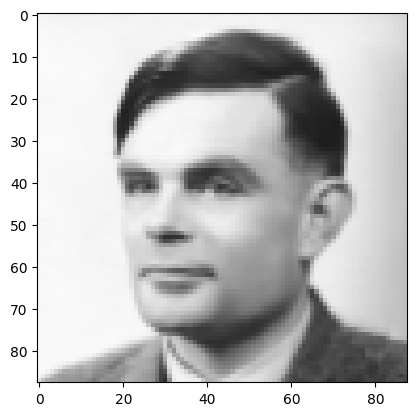

In [ ]:
model_name = "icrn_turing"
img_filename = "Turing.jpg"

# can set to True if you have saved a photo to train with
# otherwise will fetch the photo of Turing from Wikipedia
local_file = True

if local_file:
    img = Image.open(hf_dir+img_filename).convert('RGB')
else:
    url = "https://upload.wikimedia.org/wikipedia/commons/f/f8/Alan_Turing_%281951%29.jpg"
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

h, w = 88, 88

# Convert to numpy array and normalize
img_array = np.array(img) / 255.0
print(img_array.shape)
img_array = img_array[:700, 100:800]
img_array = resize(img_array, (h, w))

print(f"Shape: {img_array.shape[0]}x{img_array.shape[1]}")
plt.imshow(img_array)

print(img_array.shape)

0.0 1.0


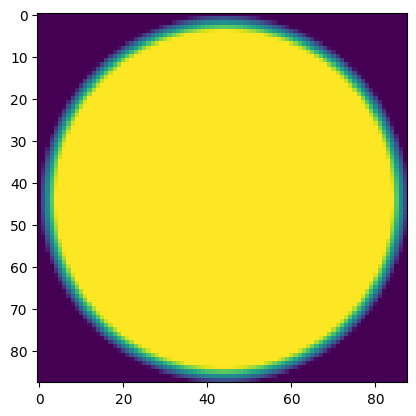

In [ ]:
def create_circular_mask(h, w, center=None, radius=None, fade_width=30):
    if center is None:
        center = (h//2, w//2)
    if radius is None:
        radius = min(center[0], center[1], h-center[0], w-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[1])**2 + (Y - center[0])**2)

    # Create the base mask
    mask = np.ones((h, w))

    # Create smooth transition
    outer_radius = radius + fade_width
    transition_zone = np.logical_and(
        dist_from_center > radius,
        dist_from_center <= outer_radius
    )

    # Apply smooth fade in transition zone
    fade_factor = (outer_radius - dist_from_center) / fade_width
    mask[transition_zone] = fade_factor[transition_zone]
    mask[dist_from_center > outer_radius] = 0

    return mask

mask = create_circular_mask(h, w, radius=40, fade_width=4)
print(mask.min(), mask.max())
plt.imshow(mask)

100 100


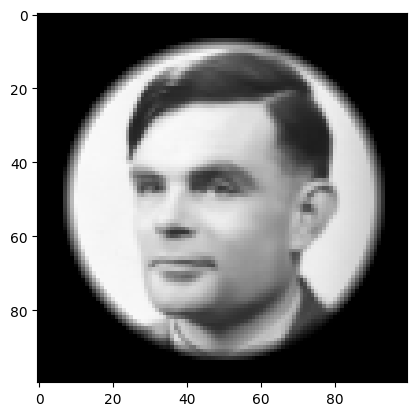

In [ ]:
TARGET_PADDING = 6

target_img = img_array

target_img = img_array * mask[..., None] + 0 * (1 - mask[..., None])

p = TARGET_PADDING
pad_target = jnp.pad(target_img, [(p, p), (p, p), (0, 0)])

H, W = pad_target.shape[:2]
print(H,W)

plt.imshow(pad_target)

## Loading and running a pre-trained model

We have included weights from a prior training run. We will load these weights and (hopefully) generate Turing after simulating from initial conditions.

(100, 100, 256)


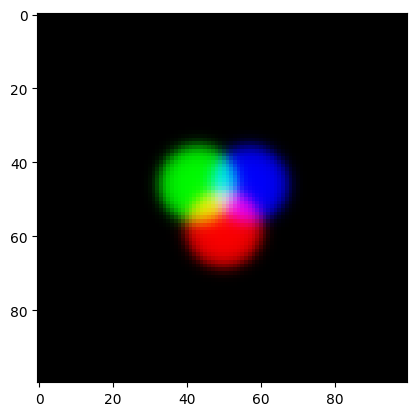

In [ ]:
# define initial conditions

def spot_image(imax, jmax, ci, cj, radius, skin):
    X, Y = jnp.meshgrid(jnp.arange(imax), jnp.arange(jmax))
    return 1.0 / (1.0 + jnp.exp(((X-ci)**2 + (Y-cj)**2 - radius**2) / (skin**2)))

def seed_at_wraparound(array, x, y, r, theta):

    mini_seed = jnp.zeros((3, H, W))
    mini_seed = mini_seed.at[0].set(spot_image(H, W, H//2,          W//2+(3*r)//4+1, r, 5))
    mini_seed = mini_seed.at[1].set(spot_image(H, W, H//2-(3*r)//4, W//2-r//2+1,     r, 5))
    mini_seed = mini_seed.at[2].set(spot_image(H, W, H//2+(3*r)//4, W//2-r//2+1,     r, 5))

    h, w = array.shape[1:]
    ii, jj = jnp.meshgrid(jnp.arange(H), jnp.arange(W), indexing='ij')

    # Calculate target indices with overflow
    target_h = (x-H//2 + ii) % h
    target_w = (y-W//2 + jj) % w

    res = array.at[:3, target_h, target_w].set(mini_seed + array[:3, target_h, target_w])
    return jnp.transpose(res, axes=(1,2,0))

seed = jnp.zeros((3, H, W))
seed = seed_at_wraparound(seed, H//2, W//2, r=10, theta=0)
seed = jnp.concatenate([seed, jnp.zeros([H, W, n-3])], axis=-1)

print(seed.shape)

plt.imshow(seed[...,:3])

In [ ]:
filename_loc = hf_dir + "ParamsBestLoss_" + model_name + "_256sp.xlsx"

xl_dict = pd.read_excel(filename_loc, sheet_name=None, header=None)

params_load = {}

for key in xl_dict.keys():
    vals = jnp.array(xl_dict[key])
    if vals.shape[1] == 1:
        vals = vals[:, 0]
    params_load[key] = vals

n_sp_loc = len(params_load["Up"])

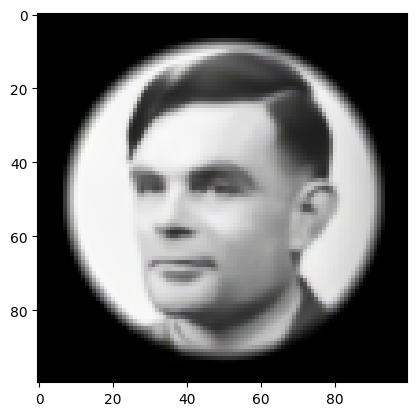

In [ ]:
concs_spec = {
    Up : seed,
    Un : 0
}

rate_data_spec = {
    Wp : params_load['Wp'],
    Wn : params_load['Wn'],
    Up_deg : params_load['Up_deg'],
    Un_deg : params_load['Un_deg']
}

diff_data_spec = {
    Up : 0.01 + (10.0 - 0.01) * sigmoid(params_load["Up"]),
    Un : 0.01 + (10.0 - 0.01) * sigmoid(params_load["Un"])
}

init_concs, rate_data, diff_data = hf_exp.dict_builder(concs_spec, rate_data_spec, diff_data_spec)
sim_concs, _ = hf_exp.simulate_time(init_concs, rate_data, diff_data, 12.5)

plt.imshow((sim_concs[Up]-sim_concs[Un])[...,:3])

## Training

The training loop both performs weight updates and collects data that will be used to generate figures. This takes roughly six hours to run with the parameters below.

In [ ]:
# initialising reaction rates and diffusion constants
N_SP=256
max_w_init = jnp.sqrt(0.6 / N_SP)

diff_data = SJDict({
    Up : jax.random.uniform(jax.random.PRNGKey(0),
                                    (N_SP,), jnp.float32, -5, 0),
    Un : jax.random.uniform(jax.random.PRNGKey(1),
                                    (N_SP,), jnp.float32, -5, 0)
})


rate_data = SJDict({
    Wp : jax.random.uniform(jax.random.PRNGKey(2),
                                    (N_SP, N_SP), jnp.float32, -max_w_init, max_w_init),
    Wn : jax.random.uniform(jax.random.PRNGKey(3),
                                    (N_SP, N_SP), jnp.float32, -max_w_init, max_w_init),
    Up_deg : jnp.ones((N_SP,)),
    Un_deg : jnp.ones((N_SP,))
})

params = (rate_data, diff_data)

# defining the optimiser and training step
schedule = optax.exponential_decay(
    init_value=0.0004,
    transition_steps=1500,
    decay_rate=0.95,
    transition_begin=50,
    staircase=False,
    end_value=None
)

optimiser = optax.chain(
    optax.clip(1.0),
    optax.adamw(learning_rate=schedule),
)

opt_state = optimiser.init(params)

loss_log = np.array([])
evolution_array = []

def simulate_rd_checkpoint(params, num_segments, segment_steps):
    rate_data, diff_data = params

    init_concs_spec = {
        Up : seed,
        Un : 0
    }

    diff_data = map1(lambda x: 0.01 + (10.0 - 0.01) * sigmoid(x), diff_data)

    init_concs, _, _ = hf_exp.dict_builder(init_concs_spec, {}, {})

    sim_concs, _ = hf_exp.simulate_segments(init_concs, rate_data, diff_data, segments=num_segments, scan_length=segment_steps)
    return sim_concs

def state_to_rgb(state):
    return (state[Up][...,:3] - state[Un][...,:3])

@partial(jax.jit, static_argnums=(2, 3))
def loss_fn(params_dict, target_state, num_segments=10, segment_steps=20):
    x = simulate_rd_checkpoint(params_dict, num_segments, segment_steps)

    loss = ((state_to_rgb(x) - target_state) ** 2).mean()

    return loss, x

@partial(jax.jit, static_argnums=(3, 4))
def step(params, opt_state, target_state, num_segments, segment_steps):
    (loss_value, simulated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, target_state, num_segments, segment_steps)
    updates, opt_state = optimiser.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value, simulated_state

def params_copy(params):
    return params[0].copy(), params[1].copy()

best_params = params_copy(params)
best_loss = np.inf
best_updates = 0

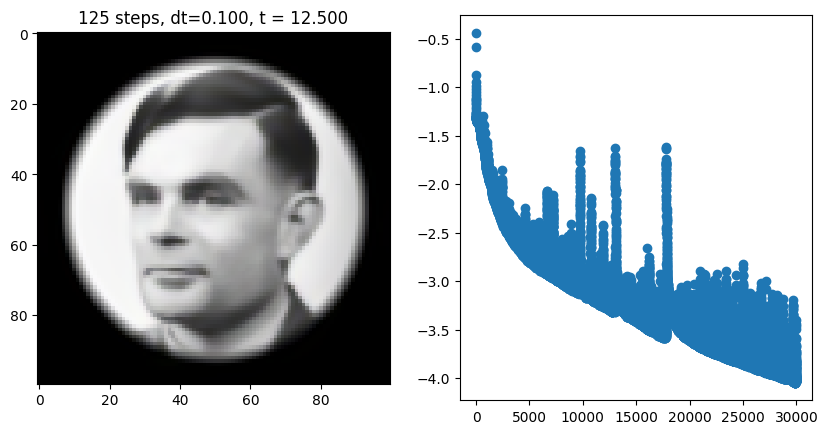

Step 30000, log loss = -3.9985, min log loss = -4.0465


Optimising CRN...: 100%|██████████| 30001/30001 [5:52:17<00:00,  1.42it/s, loss=-3.9985]


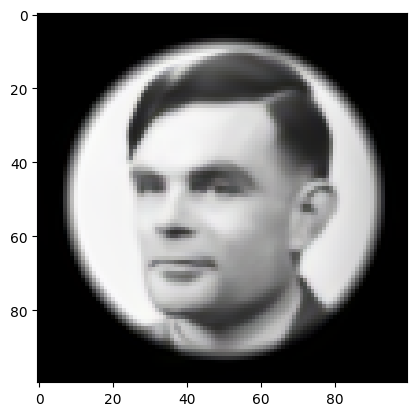

In [ ]:
# training loop

train_steps = 30_001
steps_remain = train_steps - len(loss_log)

dh = 1.0

num_segments = 5
segment_steps = 25

DISP_INTERVAL = 25

key1 = jax.random.PRNGKey(1)

target_state = pad_target

pbar = tqdm(range(steps_remain), desc="Optimising CRN...")

for _ in pbar:

    i = len(loss_log)

    params, opt_state, loss_value, simulated_state = step(params, opt_state, target_state, num_segments, segment_steps)

    log_loss = np.log10(loss_value)
    loss_log = np.append(loss_log, log_loss)

    if log_loss < best_loss:
        best_loss = log_loss
        best_params = params_copy(params)
        best_updates += 1

    if i % DISP_INTERVAL == 0:
        clear_output()
        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        axs[0].imshow(state_to_rgb(simulated_state))
        axs[0].set_title(f'{num_segments*segment_steps} steps, dt={hf_exp_params["dt"]:.3f}, t = {hf_exp_params["dt"]*num_segments*segment_steps:.3f}')
        axs[1].scatter(range(len(loss_log)), np.array(loss_log))
        plt.show()
        print(f'Step {i}, log loss = {np.log10(loss_value):.4f}, min log loss = {min(loss_log):.4f}')

    if i % DISP_INTERVAL == 0:
        evolution_array.append(state_to_rgb(simulated_state))

    if i % 1_000 == 0:
        filename = hf_dir + f"{model_name}_{n}sp_Step{i}" +  ".xlsx"
        writer = pd.ExcelWriter(filename)
        for data in params:
            for k,v in data.items():
                pd.DataFrame(v).to_excel(writer, sheet_name=str(k), header=False, index=False)
        writer.close()

        filename = hf_dir + f"ParamsBestLoss_{model_name}_{n}sp" +  ".xlsx"
        writer = pd.ExcelWriter(filename)

        for key, v in best_params[0].items():
            pd.DataFrame(v).to_excel(writer, sheet_name=str(key), header=False, index=False)
        for key, v in best_params[1].items():
            pd.DataFrame(v).to_excel(writer, sheet_name=str(key), header=False, index=False)
        writer.close()


        filename = hf_dir + f"{model_name}_{n}sp_LossLog"
        np.save(filename, np.array(loss_log))

        filename = hf_dir + f"{model_name}_{n}sp_EvolutionArray"
        np.save(filename, np.array(evolution_array))

        plt.imshow((simulated_state[Up] - simulated_state[Un])[...,:3])
        plt.savefig(hf_dir + f"{model_name}_{n}sp_Output_Step{i}")

    pbar.set_postfix(loss=f"{jnp.log10(loss_value):.4f}")

filename = hf_dir + f"ParamsBestLoss_{model_name}_{n}sp" +  ".xlsx"
writer = pd.ExcelWriter(filename)
for key, v in best_params[0].items():
    pd.DataFrame(v).to_excel(writer, sheet_name=str(key), header=False, index=False)
for key, v in best_params[1].items():
    pd.DataFrame(v).to_excel(writer, sheet_name=str(key), header=False, index=False)
writer.close()

## Figure Generation

The data necessary for the figure is generated by the prior training loop, or saved data can be loaded from the github directory.

In [ ]:
@partial(jax.jit, static_argnums=(1,2))
def tile_channels(state, grid_height, grid_width):

    array = jnp.transpose(state[Up] - state[Un], axes=(2, 0, 1))

    h_loc, w_loc = array.shape[-2:]

    tiled = array.reshape(grid_height, grid_width, h_loc, w_loc)
    tiled = jnp.transpose(tiled, (0, 2, 1, 3))

    combined = tiled.reshape(grid_height * h_loc, grid_width * w_loc)

    return combined

In [ ]:
loss_log = np.load(hf_dir + "icrn_turing_256sp_LossLog.npy")

In [ ]:
size = 15

plt.rc('font', size=size)
plt.rc('axes', titlesize=size)
plt.rc('axes', labelsize=size)
plt.rc('xtick', labelsize=size)
plt.rc('ytick', labelsize=size)
plt.rc('legend', fontsize=size)
plt.rc('figure', titlesize=size)

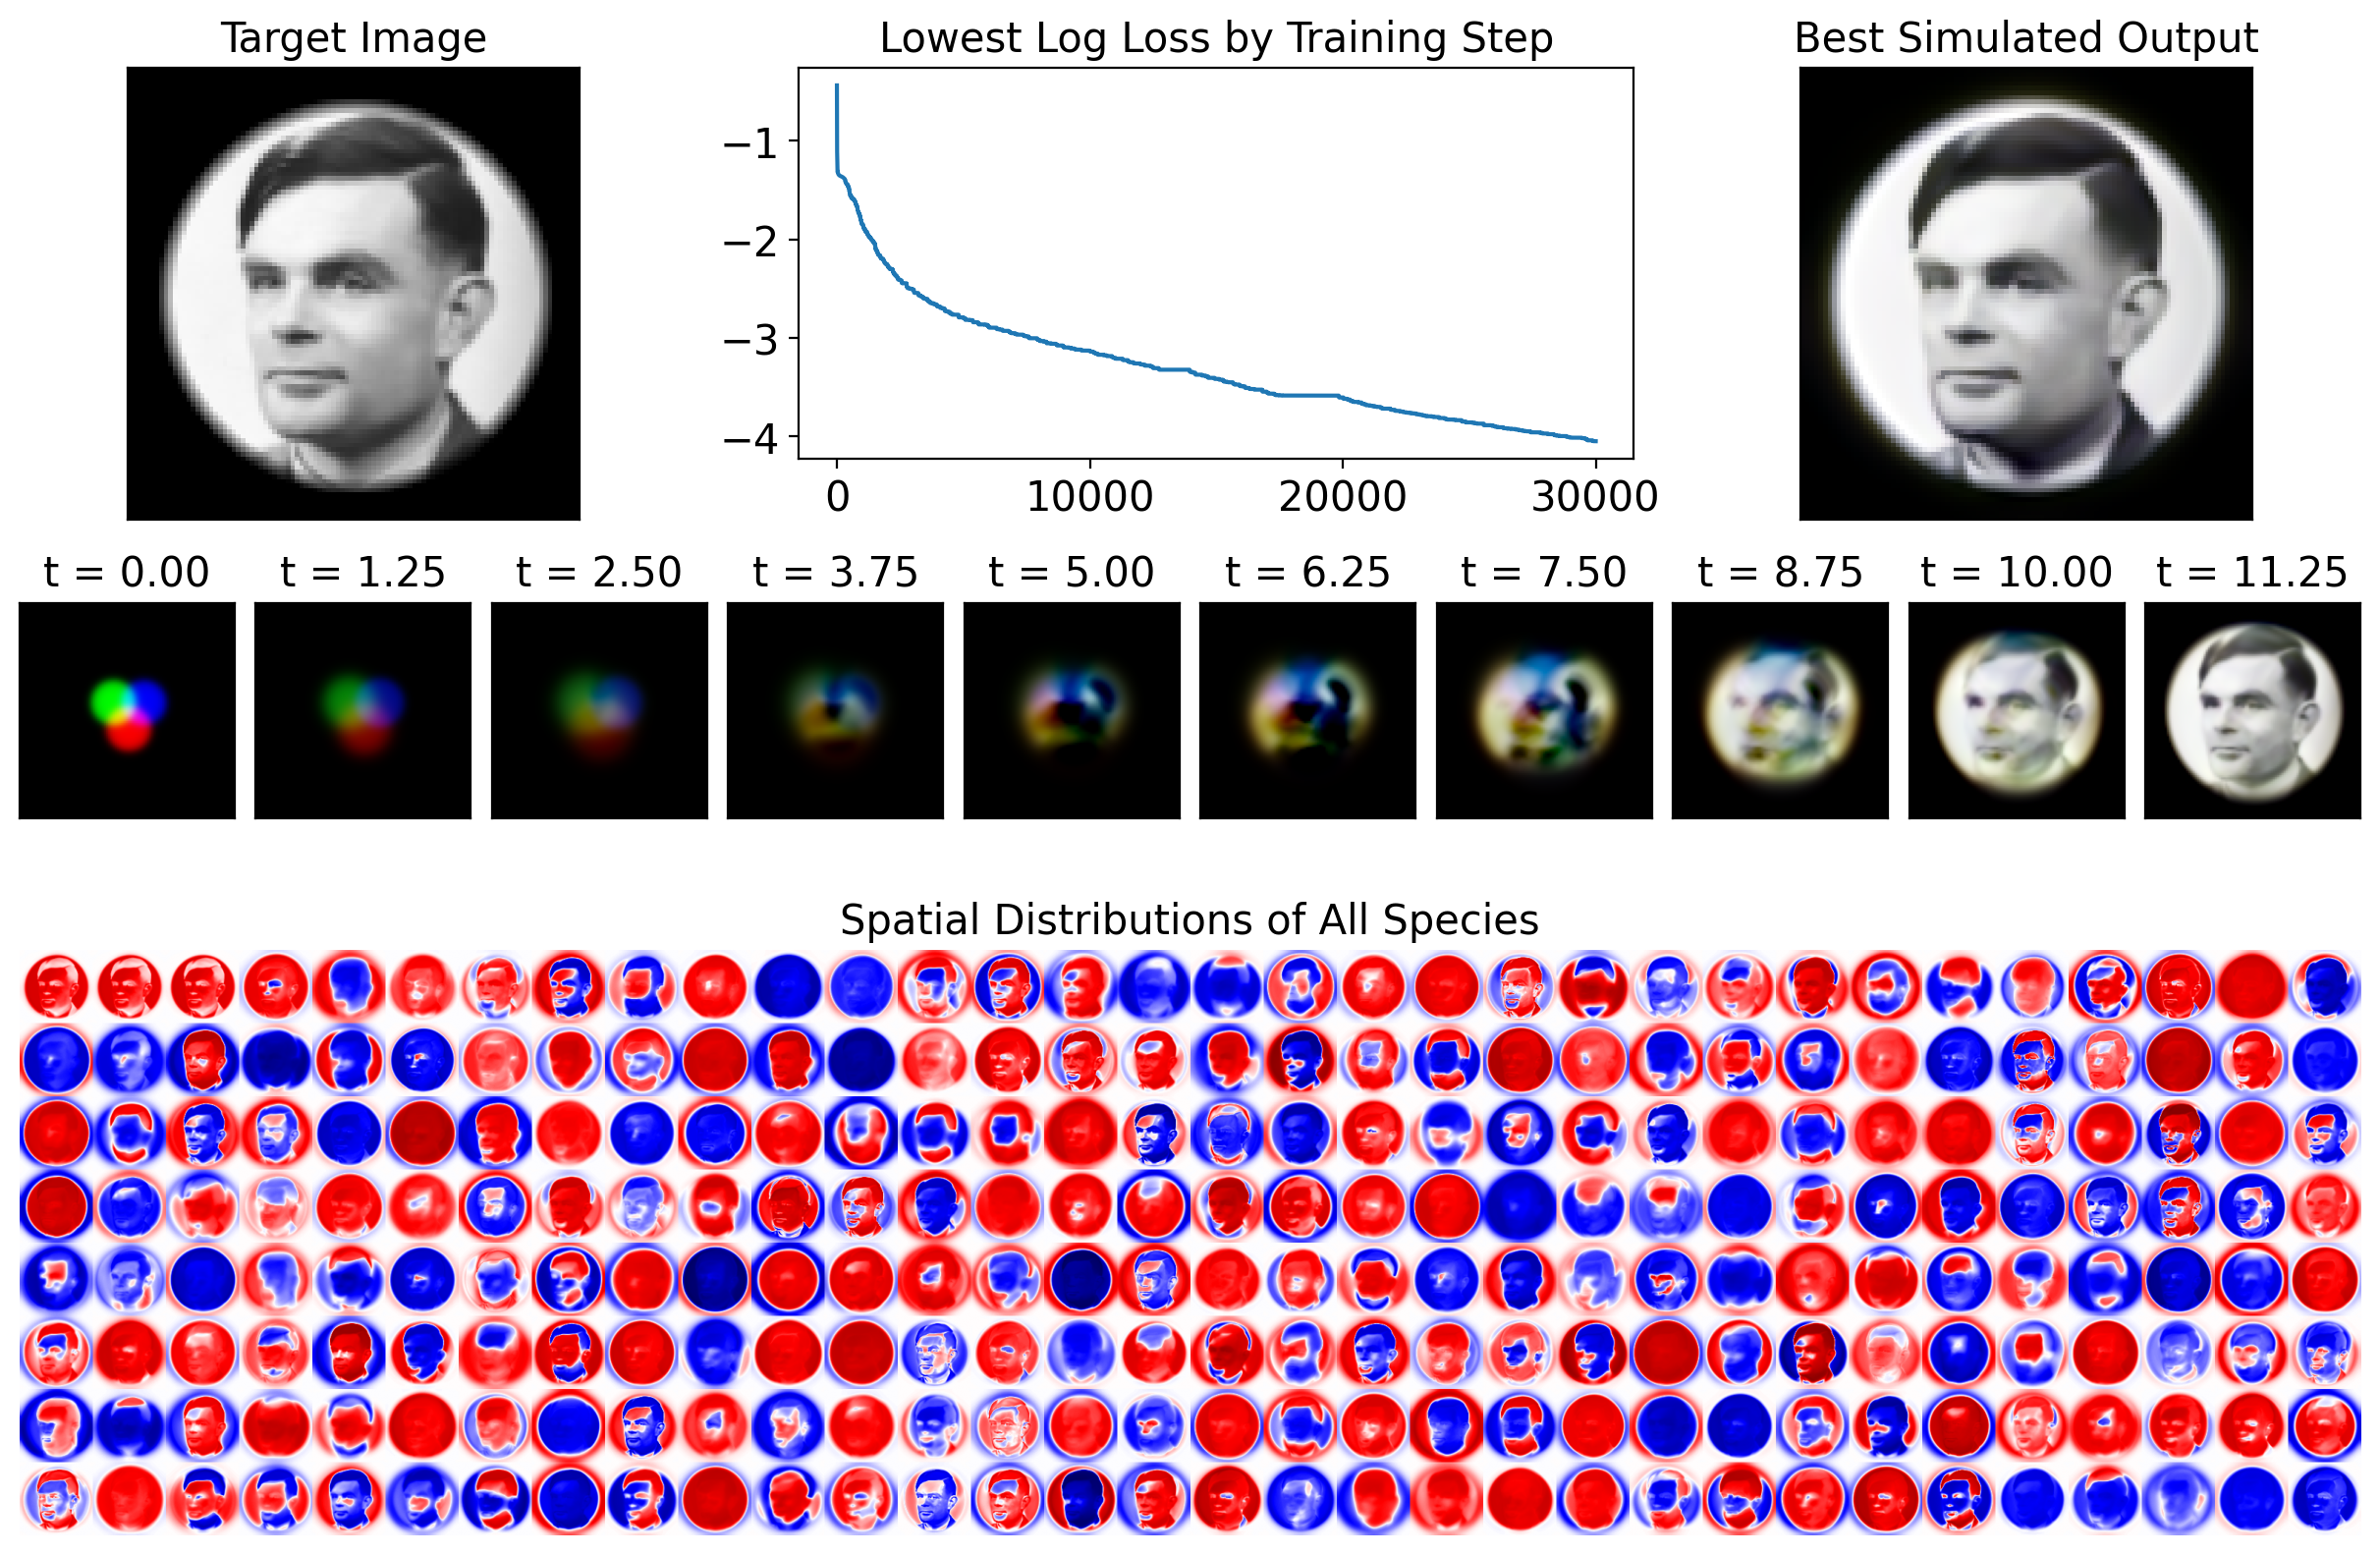

In [ ]:
dt = hf_exp_params['dt']

fig = plt.figure(layout="constrained", figsize=(12, 8), dpi=200)
subfigs = fig.subfigures(3, 1, height_ratios=[0.6, 0.4, 0.8])

axs0 = subfigs[0].subfigures(1, 3, width_ratios=[1., 1.4, 1.])

axs00 = axs0[0].subplots(1,1)
axs00.imshow(pad_target)
axs00.set_title('Target Image')
axs00.set_xticks([])
axs00.set_yticks([])

axs01 = axs0[1].subplots(1,1)
cumulative_min = np.minimum.accumulate(loss_log)
axs01.plot(range(len(loss_log)), cumulative_min)
axs01.set_title('Lowest Log Loss by Training Step')

segments_list = [0] + 9*[1.25]
n_increments = len(segments_list)

axs1 = subfigs[1].subfigures(1 ,n_increments)

state, rate_data, diff_data = hf_exp.dict_builder(concs_spec, rate_data_spec, diff_data_spec)

segment_loc = 0
for i, increment in enumerate(segments_list):
    tempax = axs1[i].subplots(1,1)

    state, _ = hf_exp.simulate_time(state, rate_data, diff_data, increment)

    segment_loc += increment
    tempax.imshow((state[Up]-state[Un])[...,:3])
    tempax.set_title(f't = {segment_loc:.2f}')
    tempax.set_xticks([])
    tempax.set_yticks([])

axs02 = axs0[2].subplots(1,1)
state, _ = hf_exp.simulate_time(state, rate_data, diff_data, 12.5-segment_loc)
axs02.imshow((state[Up]-state[Un])[...,:3])
axs02.set_title(f'Best Simulated Output')
axs02.set_xticks([])
axs02.set_yticks([])

axs2 = subfigs[2].subplots(1, 1)
grid_height, grid_width = 8, 32
combined = tile_channels(state, grid_height, grid_width)
max_val = jnp.max(jnp.abs(combined))
norm = mcolors.Normalize(vmin=-max_val, vmax=max_val)
axs2.imshow(combined, cmap='seismic', norm=norm)
axs2.axis('off')
axs2.set_title('Spatial Distributions of All Species')

plt.savefig(hf_dir + 'TuringFigure.png')